In [2]:
import numpy as np # for Array 
import pandas as pd # for DataFrames

import matplotlib.pyplot as plt # to plot
import scipy.stats as stats # to calculate spearman correlation

# Analysis MTL-Approach

In this analysis, we identify the drugs with the largest differences in MSE and examine how these differences relate to the number of interactions and involved pathways.

----

### Which drugs have the highest median MSE values?

In [25]:
# Load MSE files with baseline and naive approach
task_mses = np.loadtxt("./results/MTL/task_mses.csv", delimiter=",", skiprows=1)  # skip header
task_mses_gene = np.loadtxt("./results/MTL/naive/task_mses_gene.csv", delimiter=",", skiprows=1)  # skip header
task_mses_pathway = np.loadtxt("./results/MTL/naive/task_mses_pathway.csv", delimiter=",", skiprows=1)  # skip header

# Get index over drug names
drug_list = pd.read_csv("./data/cl_y_test_o_k1.csv", index_col=0)
drug_list = drug_list.columns

In [19]:
task_mses_direct =  pd.read_csv("./results/MTL/threshold/task_mses_direct_gene.csv")
task_mses_indirect_02 = pd.read_csv("./results/MTL/threshold/task_mses_indirect_02.csv")
task_mses_indirect_03 = pd.read_csv("./results/MTL/threshold/task_mses_indirect_03.csv")
task_mses_indirect_04 = pd.read_csv("./results/MTL/threshold/task_mses_indirect_04.csv")
task_mses_indirect_05 = pd.read_csv("./results/MTL/threshold/task_mses_indirect_05.csv")

In [26]:
# Create an DataFrame with all results
df_mse = pd.DataFrame({
    "Drug": drug_list,
    "MSE_baseline": task_mses,
    "MSE_gene": task_mses_gene,
    "MSE_pathway": task_mses_pathway
})

# Set "Drug"-column as index 
df_mse.set_index("Drug", inplace=True)

# Sort each column with Drugs with highest MSE 
for col in df_mse.columns:
    df_mse = df_mse.sort_values(by=col, ascending=False)

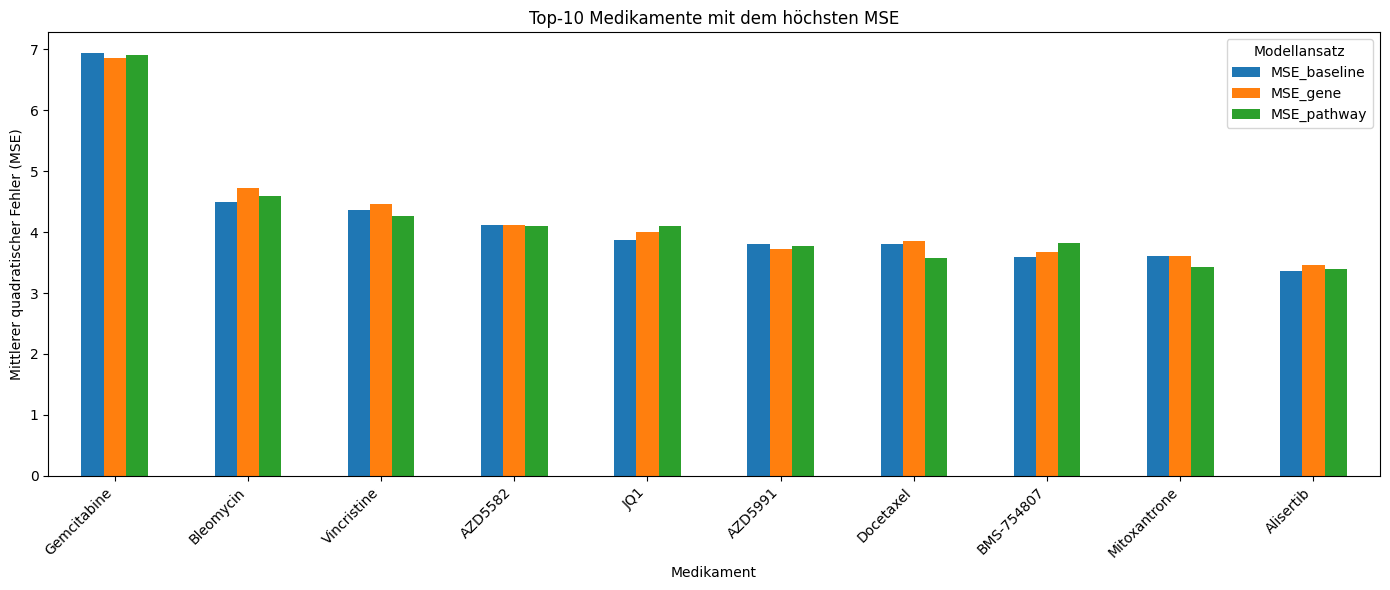

In [27]:
# Find the top N drugs with the highest MSE per approach
top_n = 10
top_drug_sets = []
for col in df_mse.columns:
    top_drugs = df_mse[col].sort_values(ascending=False).head(top_n).index
    top_drug_sets.append(set(top_drugs))

# Intersection of all top N drug sets
common_top_drugs = set.intersection(*top_drug_sets)
df_common = df_mse.loc[list(common_top_drugs)]
df_common = df_common.loc[df_common.mean(axis=1).sort_values(ascending=False).index]

# Plotting
df_common.plot(kind="bar", figsize=(14, 6))
plt.title(f"Top-{top_n} Medikamente mit dem höchsten MSE")
plt.ylabel("Mittlerer quadratischer Fehler (MSE)")
plt.xlabel("Medikament")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Modellansatz")
plt.tight_layout()
plt.show()


In [28]:
# Load the statistics table and filter it to the selected top 10 drugs with the highest MSE
statistics = pd.read_csv('./drug_statistics.csv', index_col=0)
selected_drugs = {'Docetaxel', 'AZD5582', 'BMS-754807', 'AZD5991', 'Mitoxantrone', 'JQ1', 'Vincristine', 'Bleomycin', 'Gemcitabine', 'Alisertib'}
statistics_subset = statistics[statistics.index.isin(selected_drugs)]

In [29]:
statistics_subset

,Tested_Samples,Mean,Median,Std,Variance,Skewness,CV
Drug,,,,,,,
Docetaxel,263,-3.471703,-4.044488,2.285939,5.225517,0.662730,-0.658449
Gemcitabine,252,-0.448804,-1.001651,3.269576,10.690129,0.158158,-7.285087
Alisertib,242,1.527927,1.661884,2.369802,5.615961,-0.164276,1.550991
Mitoxantrone,238,0.301861,0.261782,2.305457,5.315134,0.144035,7.637469
AZD5991,239,3.555350,4.318087,2.862550,8.194192,-0.747668,0.805139
Vincristine,238,-1.743570,-2.284809,2.744564,7.532634,0.547991,-1.574106
AZD5582,234,2.157083,1.931485,2.194600,4.816268,-0.431702,1.017392
JQ1,16,2.564470,3.038926,1.827445,3.339554,-0.630055,0.712601
BMS-754807,15,0.945185,1.273567,1.879175,3.531300,-0.552742,1.988157


### How many interactions do the drugs with the highest MSE have?

In [30]:
dgi_matrix = pd.read_csv("./data/global_gene_interaction_matrix.csv", index_col=0).astype(np.float32)
pathway_matrix = pd.read_csv("./data/drug_pathway_binary_matrix.csv", index_col=0).astype(np.float32)

In [31]:
# Number of interactions per drug (rows)
dgi_interaction_counts = dgi_matrix.sum(axis=1)
pathway_interaction_counts = pathway_matrix.sum(axis=1)

# Add interactions as new columns to the MSE DataFrame
df_mse["DGI_interactions"] = dgi_interaction_counts
df_mse["Pathway_interactions"] = pathway_interaction_counts

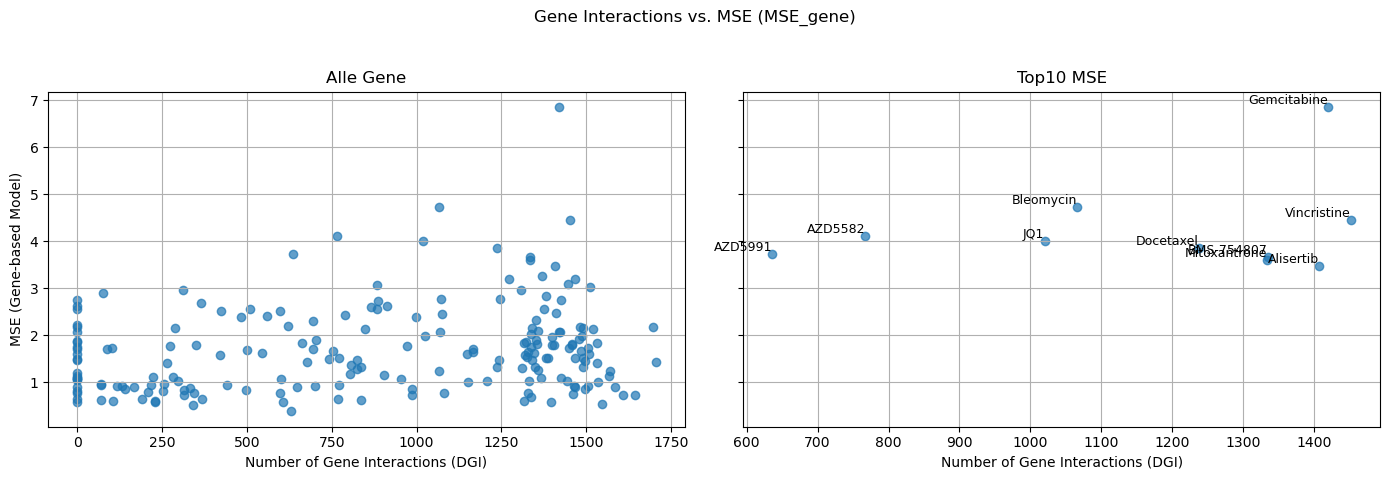

In [24]:
import matplotlib.pyplot as plt

# Liste der gewünschten Drugs
selected_drugs = {'Docetaxel', 'AZD5582', 'BMS-754807', 'AZD5991',
                  'Mitoxantrone', 'JQ1', 'Vincristine', 'Bleomycin',
                  'Gemcitabine', 'Alisertib'}

# Filtere den DataFrame auf diese Drugs
df_selected = df_mse[df_mse.index.isin(selected_drugs)]

# Erstelle nebeneinanderliegende Subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Plot 1: Alle Daten
axes[0].scatter(df_mse["DGI_interactions"], df_mse["MSE_gene"], alpha=0.7)
axes[0].set_title("Alle Gene")
axes[0].set_xlabel("Number of Gene Interactions (DGI)")
axes[0].set_ylabel("MSE (Gene-based Model)")
axes[0].grid(True)

# Plot 2: Nur ausgewählte Drugs, mit Beschriftung
axes[1].scatter(df_selected["DGI_interactions"], df_selected["MSE_gene"], alpha=0.7)
for idx, row in df_selected.iterrows():
    axes[1].text(row['DGI_interactions'], row['MSE_gene'], str(idx),
                 fontsize=9, ha='right', va='bottom')
axes[1].set_title("Top10 MSE")
axes[1].set_xlabel("Number of Gene Interactions (DGI)")
axes[1].grid(True)

# Layout und Anzeige
plt.suptitle("Gene Interactions vs. MSE (MSE_gene)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



### Threshold

In [17]:
import pandas as pd

# Load MSE files with baseline and naive approach
task_mses_direct =  pd.read_csv("./results/MTL/threshold/task_mses_direct_gene.csv")
task_mses_indirect_02 = pd.read_csv("./results/MTL/threshold/task_mses_indirect_02.csv")
task_mses_indirect_03 = pd.read_csv("./results/MTL/threshold/task_mses_indirect_03.csv")
task_mses_indirect_04 = pd.read_csv("./results/MTL/threshold/task_mses_indirect_04.csv")
task_mses_indirect_05 = pd.read_csv("./results/MTL/threshold/task_mses_indirect_05.csv")
task_mses_indirect_06 = pd.read_csv("./results/MTL/threshold/task_mses_indirect_06.csv")
task_mses_indirect_07 = pd.read_csv("./results/MTL/threshold/task_mses_indirect_07.csv")

# Optional: Liste aller DataFrames
mse_dfs = [
    task_mses_direct,
    task_mses_indirect_02,
    task_mses_indirect_03,
    task_mses_indirect_04,
    task_mses_indirect_05,
    task_mses_indirect_06,
    task_mses_indirect_07
]

# Benenne die Spalten um (falls alle MSEs in der gleichen Spalte stehen, z.B. "MSE")
col_names = [
    "direct",
    "indirect_02",
    "indirect_03",
    "indirect_04",
    "indirect_05",
    "indirect_06",
    "indirect_07"
]

# Stelle sicher, dass alle DataFrames eine "Drug"-Spalte haben
# und baue df_mse durch Zusammenfügen
df_mse = pd.DataFrame()

for df, name in zip(mse_dfs, col_names):
    df = df.set_index("Drug")  # Setze "Drug" als Index
    df.columns = [name]        # Benenne Spalte mit MSE-Werten um
    df_mse = pd.concat([df_mse, df], axis=1)

# Jetzt enthält df_mse die MSEs je Drug in den verschiedenen Methoden

# Sortiere jede Spalte nach höchstem MSE (optional: zeilenweise sortieren für jede Spalte)
for col in df_mse.columns:
    df_mse = df_mse.sort_values(by=col, ascending=False)

# Zeige das Ergebnis
print(df_mse.head())


               direct  indirect_02  indirect_03  indirect_04  indirect_05  \
Drug                                                                        
Gemcitabine  6.814561     6.966257     6.868599     6.950562     6.881531   
Bleomycin    4.522351     4.707551     4.742613     4.734668     4.715827   
Vincristine  4.362927     4.432077     4.470614     4.488941     4.436277   
AZD5582      4.202082     4.054654     4.081491     4.108198     4.112215   
JQ1          3.681069     3.926685     3.987410     4.005684     4.019101   

             indirect_06  indirect_07  
Drug                                   
Gemcitabine     6.845510     6.834412  
Bleomycin       4.689866     4.609690  
Vincristine     4.430617     4.454709  
AZD5582         4.105661     4.139404  
JQ1             4.111029     4.086994  


{'AZD5991', 'AZD5582', 'Vincristine', 'BMS-754807', 'Bleomycin', 'Gemcitabine', 'JQ1', 'Docetaxel', 'Mitoxantrone'}
Gemeinsame Top-10-Drugs über alle Ansätze: 9 gefunden


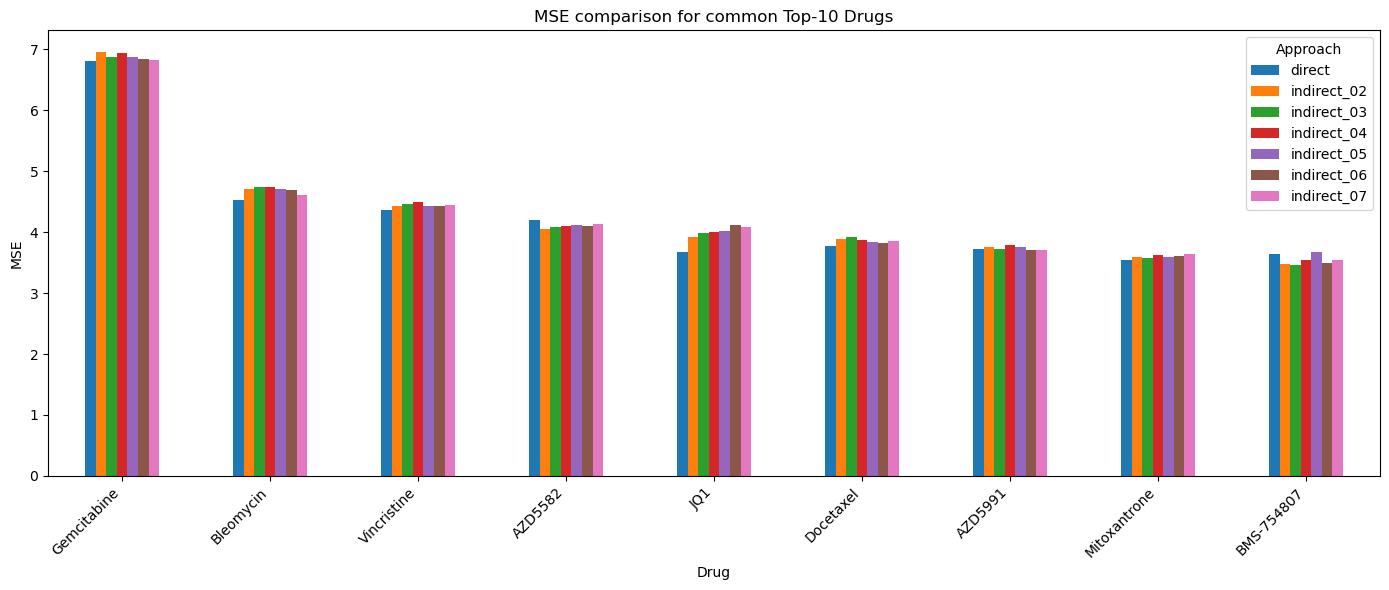

In [18]:
# Anzahl der Top-N Drugs pro Ansatz
top_n = 10

# 1. Finde die Top-N Drugs mit höchstem MSE pro Ansatz
top_drug_sets = []
for col in df_mse.columns:
    top_drugs = df_mse[col].sort_values(ascending=False).head(top_n).index
    top_drug_sets.append(set(top_drugs))

# 2. Schnittmenge aller Top-N-Drogensätze
common_top_drugs = set.intersection(*top_drug_sets)
print(common_top_drugs)
print(f"Gemeinsame Top-{top_n}-Drugs über alle Ansätze: {len(common_top_drugs)} gefunden")

# 3. Filtere den DataFrame auf diese Drugs
df_common = df_mse.loc[list(common_top_drugs)]

# 4. Sortiere nach einem festen Kriterium (z. B. Mittelwert)
df_common = df_common.loc[df_common.mean(axis=1).sort_values(ascending=False).index]

# 5. Plotten
df_common.plot(kind="bar", figsize=(14, 6))
plt.title(f"MSE comparison for common Top-{top_n} Drugs")
plt.ylabel("MSE")
plt.xlabel("Drug")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Approach")
plt.tight_layout()
plt.show()

### Biological ways

                     Gene_set                                               Term  Overlap       P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  Combined Score                                              Genes
0  GO_Biological_Process_2023               Protein Phosphorylation (GO:0006468)  112/500  1.131571e-79      3.683264e-76            0                     0   16.026894     2913.378610  ATF2;RPS6KA3;STK11;AKT2;PRKACG;CHEK2;CHEK1;RPS...
1  GO_Biological_Process_2023  Regulation Of Cell Population Proliferation (G...  120/766  8.316388e-67      1.353492e-63            0                     0   10.416257     1584.885317  CSF1;IRS1;IRS2;FGF2;ETS1;FGF3;FGF4;CRKL;FGF5;F...
2  GO_Biological_Process_2023  Transmembrane Receptor Protein Tyrosine Kinase...   80/284  8.966862e-65      9.729046e-62            0                     0   20.116503     2966.671101  RET;GSK3B;GSK3A;FLT1;CSF1;IRS1;IRS2;FGF2;FGF3;...
3  GO_Biological_Process_2023       Regulation Of Apopto

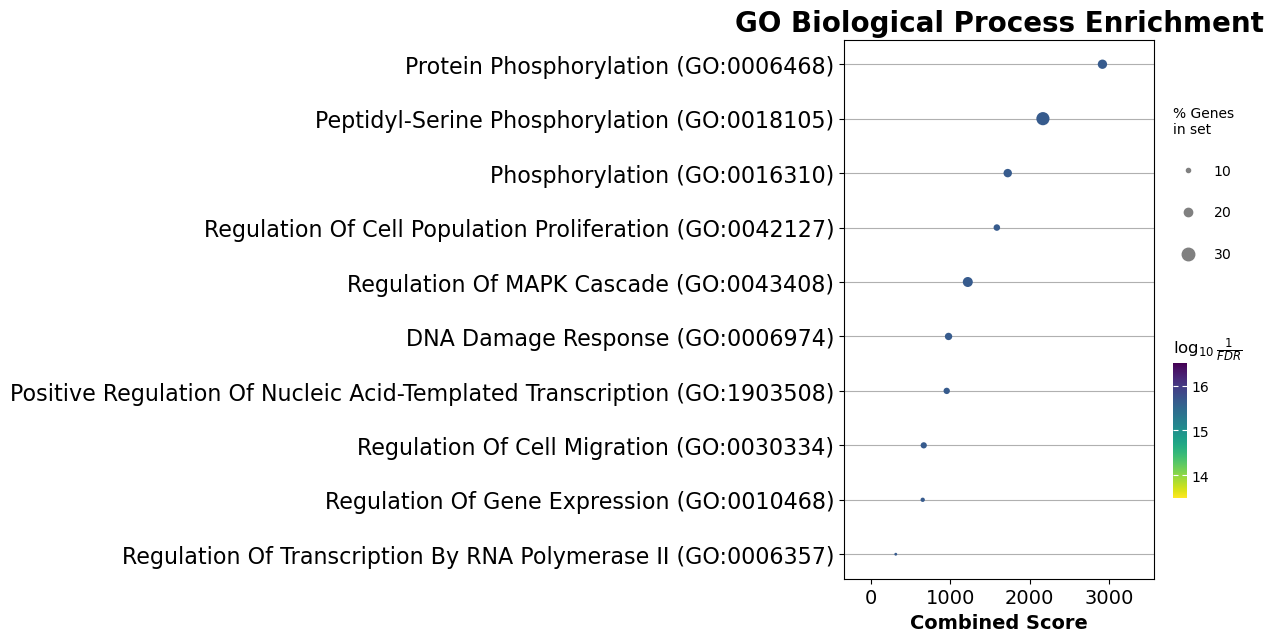

In [77]:
import gseapy as gp

# Beispiel mit deiner Genliste
gene_list = genes_with_10_hits.index.tolist()

# GO enrichment analysis
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets='GO_Biological_Process_2023',
                 organism='Human',
                 outdir=None)

print(enr.results.head())

import matplotlib.pyplot as plt

# Dotplot für die Enrichment-Ergebnisse
gp.dotplot(enr.res2d, title='GO Biological Process Enrichment', figsize=(5, 7), cutoff=0.05)
plt.show()

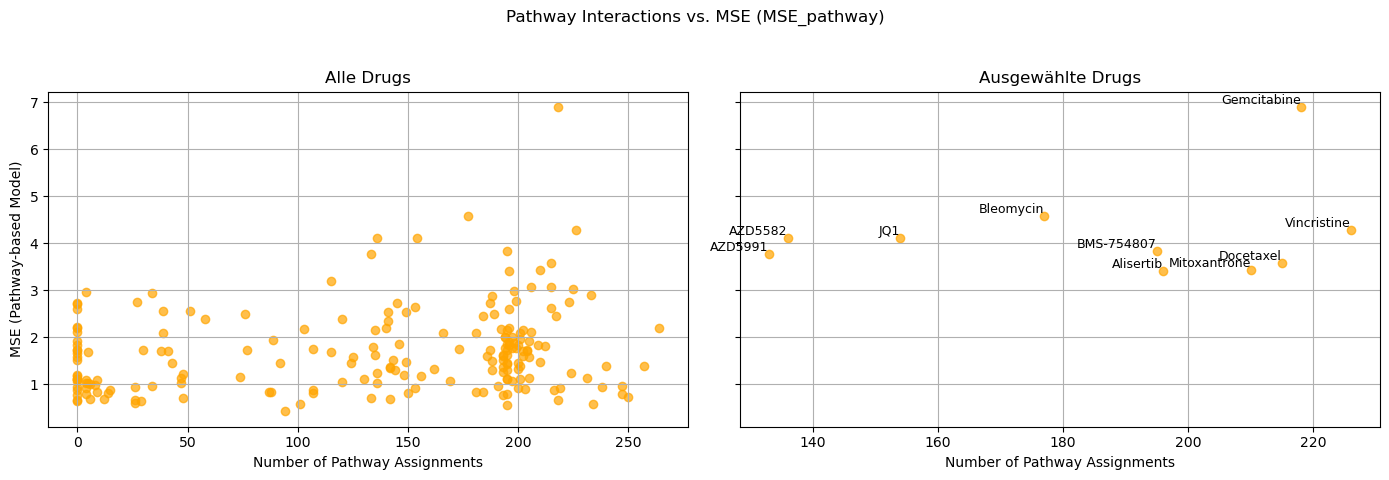

In [25]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Plot 1: Alle Daten
axes[0].scatter(df_mse["Pathway_interactions"], df_mse["MSE_pathway"], alpha=0.7, color="orange")
axes[0].set_title("Alle Drugs")
axes[0].set_xlabel("Number of Pathway Assignments")
axes[0].set_ylabel("MSE (Pathway-based Model)")
axes[0].grid(True)

# Plot 2: Nur ausgewählte Drugs, mit Beschriftung
axes[1].scatter(df_selected["Pathway_interactions"], df_selected["MSE_pathway"], alpha=0.7, color="orange")
for idx, row in df_selected.iterrows():
    axes[1].text(row['Pathway_interactions'], row['MSE_pathway'], str(idx),
                 fontsize=9, ha='right', va='bottom')
axes[1].set_title("Ausgewählte Drugs")
axes[1].set_xlabel("Number of Pathway Assignments")
axes[1].grid(True)

# Layout und Anzeige
plt.suptitle("Pathway Interactions vs. MSE (MSE_pathway)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [1]:
import pandas as pd
import numpy as np

dgi_matrix = pd.read_csv("./data/global_gene_interaction_matrix.csv", index_col=0).astype(np.float32)
pathway_matrix = pd.read_csv("./data/drug_pathway_binary_matrix.csv", index_col=0).astype(np.float32)

selected_drugs = {'Docetaxel', 'AZD5582', 'BMS-754807', 'AZD5991',
                  'Mitoxantrone', 'JQ1', 'Vincristine', 'Bleomycin',
                  'Gemcitabine', 'Alisertib'}

# Filter auf ausgewählte Drugs (Zeilen)
pathway_selected = pathway_matrix.loc[pathway_matrix.index.intersection(selected_drugs)]
dgi_selected = dgi_matrix.loc[dgi_matrix.index.intersection(selected_drugs)]

In [ ]:
from gprofiler import GProfiler
import matplotlib.pyplot as plt
import seaborn as sns

gp = GProfiler(return_dataframe=True)
gene_list = dgi_selected.columns[(dgi_selected.sum(axis=0) == 10)].tolist()

# Enrichment Analyse gegen GO, KEGG etc.
results = gp.profile(organism='hsapiens', query=gene_list)
print(results.head())


  source      native                                     name        p_value  \
0  GO:BP  GO:0035556        intracellular signal transduction  1.779633e-184   
1  GO:BP  GO:0051716            cellular response to stimulus  2.846471e-157   
2  GO:BP  GO:0048522  positive regulation of cellular process  2.400813e-147   
3  GO:BP  GO:0016310                          phosphorylation  3.842253e-143   
4  GO:BP  GO:0048583       regulation of response to stimulus  4.691254e-142   

   significant                                        description  term_size  \
0         True  "The process in which a signal is passed on to...       2965   
1         True  "Any process that results in a change in state...       7376   
2         True  "Any process that activates or increases the f...       5920   
3         True  "The process of introducing a phosphate group ...       1320   
4         True  "Any process that modulates the frequency, rat...       3993   

   query_size  intersection_size  effe

/tmp/ipykernel_3289346/798502561.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


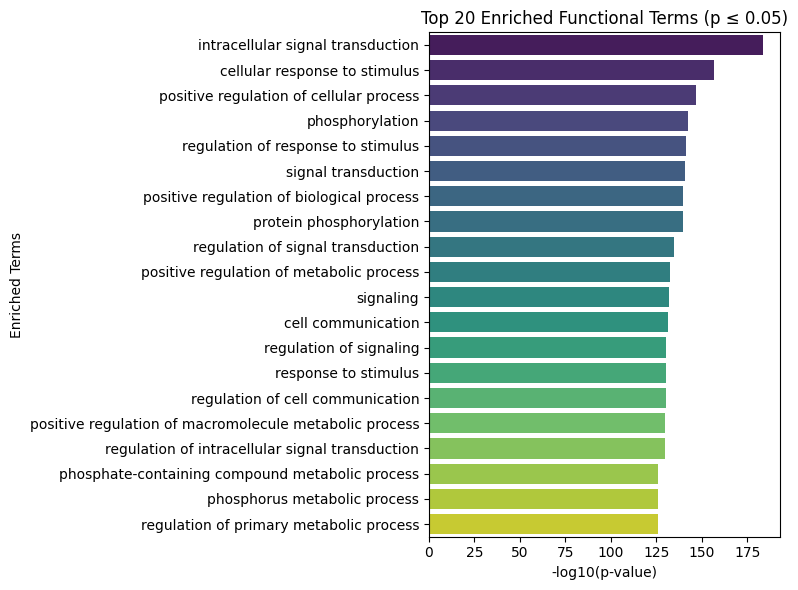

In [20]:
sig_results = results[results['p_value'] <= 0.05]

# Sortiere nach p-Wert (aufsteigend)
sig_results = sig_results.sort_values('p_value')

# Nimm z.B. die Top 20 Terms
top_terms = sig_results.head(20)

# Plot: Barplot mit -log10(p-value) für bessere Sichtbarkeit
plt.figure(figsize=(8,6))
sns.barplot(
    x=-np.log10(top_terms['p_value']),
    y=top_terms['name'],
    palette='viridis'
)
plt.xlabel('-log10(p-value)')
plt.ylabel('Enriched Terms')
plt.title('Top 20 Enriched Functional Terms (p ≤ 0.05)')
plt.tight_layout()
plt.show()


- Signaltransduktion , Proteinphosphorylierung  und Metabolismus von Phosphat-haltigen Verbindungen 

  source      native                    name        p_value  significant  \
0   KEGG  KEGG:05200      Pathways in cancer  3.472364e-123         True   
1   KEGG  KEGG:04010  MAPK signaling pathway  2.145856e-110         True   
2     WP   WP:WP5434         Cancer pathways  4.694560e-104         True   
3     WP    WP:WP382          MAPK signaling  4.929804e-100         True   
4     WP   WP:WP5087    Pleural mesothelioma   2.947606e-72         True   

              description  term_size  query_size  intersection_size  \
0      Pathways in cancer        527         434                192   
1  MAPK signaling pathway        301         434                145   
2         Cancer pathways        505         448                174   
3          MAPK signaling        245         448                127   
4    Pleural mesothelioma        435         448                136   

   effective_domain_size  precision    recall    query       parents  
0                   8484   0.442396  0.364326

/tmp/ipykernel_3289346/773630462.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='p_value', y='name', data=top_pathways, palette='viridis')


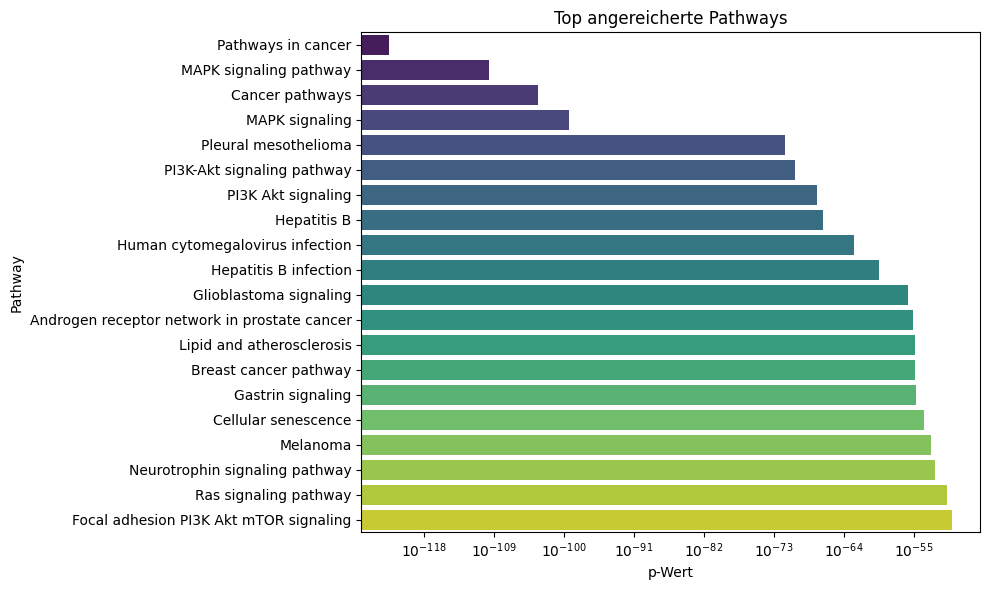

In [23]:
from gprofiler import GProfiler
import matplotlib.pyplot as plt
import seaborn as sns

# Initialisiere GProfiler
gp = GProfiler(return_dataframe=True)

# Deine Genliste (wie in deinem Code)
gene_list = dgi_selected.columns[(dgi_selected.sum(axis=0) == 10)].tolist()

# Führe Profiling mit ausgewählten Namespace/Quellen durch
results = gp.profile(
    organism='hsapiens',
    query=gene_list,
    sources=['KEGG', 'REACTOME', 'WP']  # WP = WikiPathways
)

print(results.head())

# Filtere nur signifikante Ergebnisse
significant_results = results[results['p_value'] < 0.05]

# Sortiere nach p-Wert
top_pathways = significant_results.sort_values('p_value').head(20)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x='p_value', y='name', data=top_pathways, palette='viridis')
plt.title('Top angereicherte Pathways')
plt.xlabel('p-Wert')
plt.ylabel('Pathway')
plt.xscale('log')
plt.tight_layout()
plt.show()

In [13]:
# Filter auf ausgewählte Drugs (Zeilen)
pathway_selected = pathway_matrix.loc[pathway_matrix.index.intersection(selected_drugs)]
dgi_selected = dgi_matrix.loc[dgi_matrix.index.intersection(selected_drugs)]

# Summiere über alle Spalten (Gene), sortiere nach Häufigkeit
gene_freq = dgi_selected.sum(axis=0).sort_values(ascending=False)

# Zeige die Top 10 am häufigsten getroffenen Gene
print(gene_freq.head(10))

# Summiere über alle Spalten (Pathways), sortiere nach Häufigkeit
pathway_freq = pathway_selected.sum(axis=0).sort_values(ascending=False)

# Zeige die Top 10 am häufigsten betroffenen Pathways
print(pathway_freq.head(10))

MAPK8     10.0
IDH2      10.0
SHC1      10.0
PPP3CC    10.0
PPP3CB    10.0
SHH       10.0
SIAH1     10.0
PPP3CA    10.0
IGF1      10.0
SKP1      10.0
dtype: float32
p53 signaling pathway                                  10.0
FoxO signaling pathway                                 10.0
Growth hormone synthesis, secretion and action         10.0
PI3K-Akt signaling pathway                             10.0
GnRH signaling pathway                                 10.0
Pancreatic cancer                                      10.0
Parathyroid hormone synthesis, secretion and action    10.0
Pathogenic Escherichia coli infection                  10.0
Pathways in cancer                                     10.0
Pathways of neurodegeneration                          10.0
dtype: float32


# Analysis DA-Approach

### Result

In [ ]:
# Load each DataFrame with baseline and naive approach
preds_AUC_gene = pd.read_csv('./results/DA/preds_AUC_naiv_gene_level.csv', index_col=0)
preds_AUC_baseline = pd.read_csv('./results/DA/preds_AUC.csv', index_col=0)
preds_AUC_pathway = pd.read_csv('./results/DA/preds_AUC_naiv_pathway_level.csv', index_col=0)


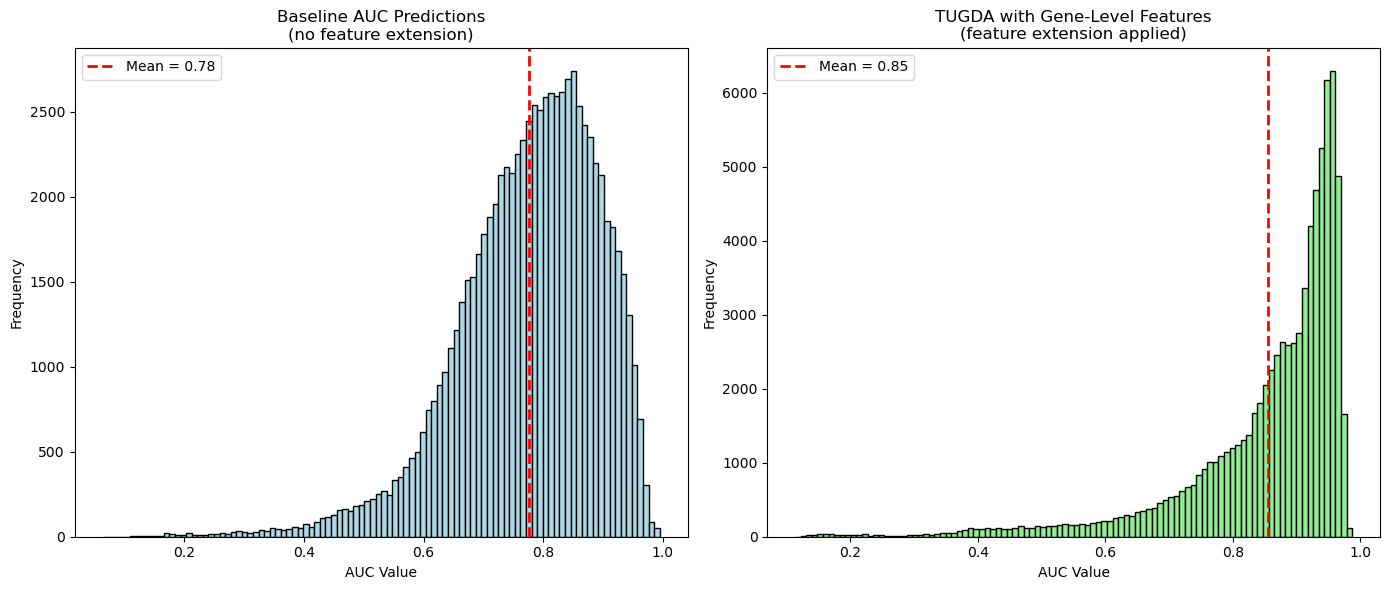

In [3]:
# drug sensitivity score AUC
# Je kleiner der AUC-Wert, desto empfindlicher ist das Modell gegenüber dem Medikament (weil weniger Dosis nötig ist, um Effekt zu erzielen)
# Ein hoher AUC-Wert bedeutet Resistenz bzw. geringere Wirkung des Medikaments.

import matplotlib.pyplot as plt
import numpy as np

# Wandle in 1D Arrays um
gene_values = preds_AUC_gene.values.flatten()
baseline_values = preds_AUC_baseline.values.flatten()

# Plot mit zwei Subplots (nebeneinander)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Linkes Histogramm - Baseline
axes[0].hist(baseline_values, bins=100, color='lightblue', edgecolor='black')
axes[0].axvline(x=np.mean(baseline_values), color='red', linestyle='--', linewidth=2,
                label=f'Mean = {np.mean(baseline_values):.2f}')
axes[0].set_xlabel('AUC Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Baseline AUC Predictions\n(no feature extension)')
axes[0].legend()

# Rechtes Histogramm - Gene-Level Extension
axes[1].hist(gene_values, bins=100, color='lightgreen', edgecolor='black')
axes[1].axvline(x=np.mean(gene_values), color='red', linestyle='--', linewidth=2,
                label=f'Mean = {np.mean(gene_values):.2f}')
axes[1].set_xlabel('AUC Value')
axes[1].set_ylabel('Frequency')
axes[1].set_title('TUGDA with Gene-Level Features\n(feature extension applied)')
axes[1].legend()

# Layout optimieren und anzeigen
plt.tight_layout()
plt.show()


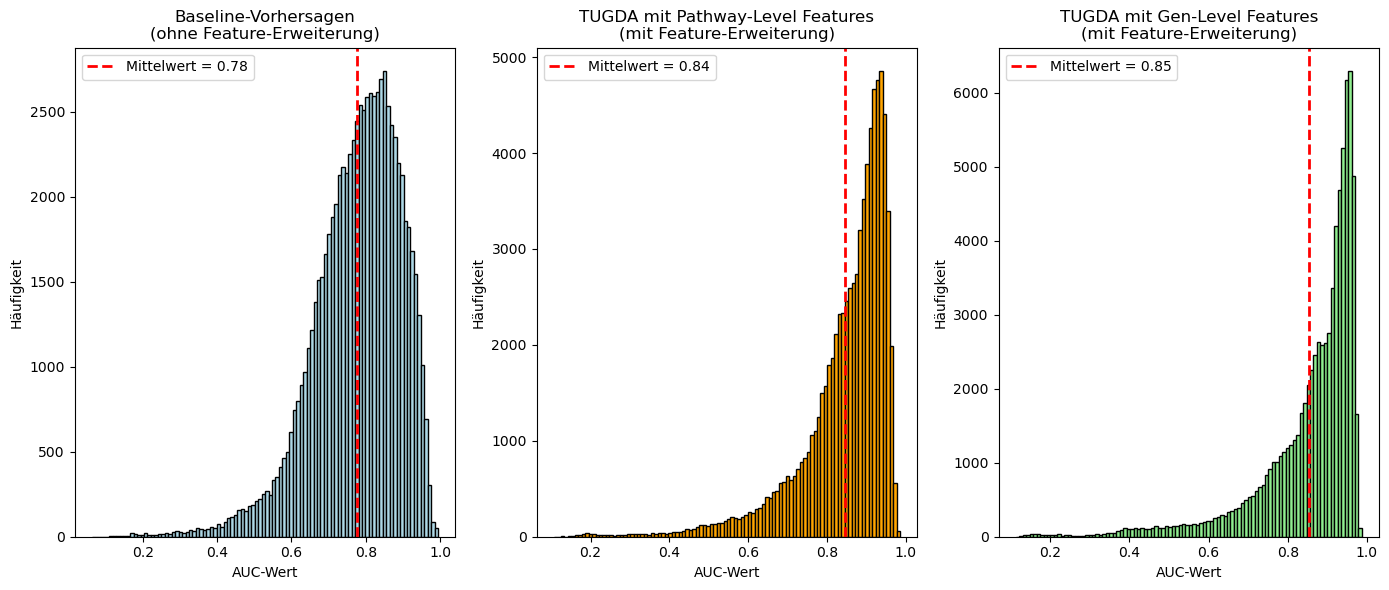

In [96]:
import matplotlib.pyplot as plt
import numpy as np

# Wandle in 1D Arrays um
gene_values = preds_AUC_gene.values.flatten()
baseline_values = preds_AUC_baseline.values.flatten()
pathway_values = preds_AUC_pathway.values.flatten()

# Plot mit zwei Subplots (nebeneinander)
fig, axes = plt.subplots(1, 3, figsize=(14, 6))

# Linkes Histogramm - Baseline
axes[0].hist(baseline_values, bins=100, color='lightblue', edgecolor='black')
axes[0].axvline(x=np.mean(baseline_values), color='red', linestyle='--', linewidth=2,
                label=f'Mittelwert = {np.mean(baseline_values):.2f}')
axes[0].set_xlabel('AUC-Wert')
axes[0].set_ylabel('Häufigkeit')
axes[0].set_title('Baseline-Vorhersagen\n(ohne Feature-Erweiterung)')
axes[0].legend()

# Mittleres Histogramm - Pathway-Level Extension
axes[1].hist(pathway_values, bins=100, color='orange', edgecolor='black')
axes[1].axvline(x=np.mean(pathway_values), color='red', linestyle='--', linewidth=2,
                label=f'Mittelwert = {np.mean(pathway_values):.2f}')
axes[1].set_xlabel('AUC-Wert')
axes[1].set_ylabel('Häufigkeit')
axes[1].set_title('TUGDA mit Pathway-Level Features\n(mit Feature-Erweiterung)')
axes[1].legend()

# Rechtes Histogramm - Gene-Level Extension
axes[2].hist(gene_values, bins=100, color='lightgreen', edgecolor='black')
axes[2].axvline(x=np.mean(gene_values), color='red', linestyle='--', linewidth=2,
                label=f'Mittelwert = {np.mean(gene_values):.2f}')
axes[2].set_xlabel('AUC-Wert')
axes[2].set_ylabel('Häufigkeit')
axes[2].set_title('TUGDA mit Gen-Level Features\n(mit Feature-Erweiterung)')
axes[2].legend()

# Layout optimieren und anzeigen
plt.tight_layout()
plt.show()

Korrelation
- df_expression = 399 Zeilen mit 1764 Genen
- df_response = 399 Zeilen mit 200 Drugs
 
⚠️ Wichtige Einschränkungen: 

Trotzdem gibt es Dinge, die du beachten solltest: 
Nur lineare Zusammenhänge
	
Korrelation erfasst nur lineare Beziehungen. Nicht-lineare Effekte bleiben unentdeckt.
Keine Wechselwirkungen zwischen Genen
	
Es wird immer nur ein Gen isoliert betrachtet – aber in der Realität wirken Gene oft zusammen.
Batch-Effekte / Heterogenität der PDX-Proben
	
Die Proben kommen von unterschiedlichen Quellen, Gewebetypen etc. Das kann die Ergebnisse beeinflussen.
Multiple Testing Problem
	
Bei Tausenden von Genen und mehreren Medikamenten: viele Korrelationen werden zufällig signifikant → Benutze FDR-Korrektur!

In [97]:
# mean preds_AUC_baseline pro Drug

means_baseline = preds_AUC_baseline.mean()
means_gene = preds_AUC_gene.mean()
means_pathway = preds_AUC_pathway.mean()

gdsc_dataset = pd.read_csv('./data/GDSCDA_fpkm_AUC_all_drugs.zip', index_col=0)
gdsc_drugs = gdsc_dataset.iloc[:, -200:]
means_drugs = gdsc_drugs.mean() # NaN values are automatically skipped




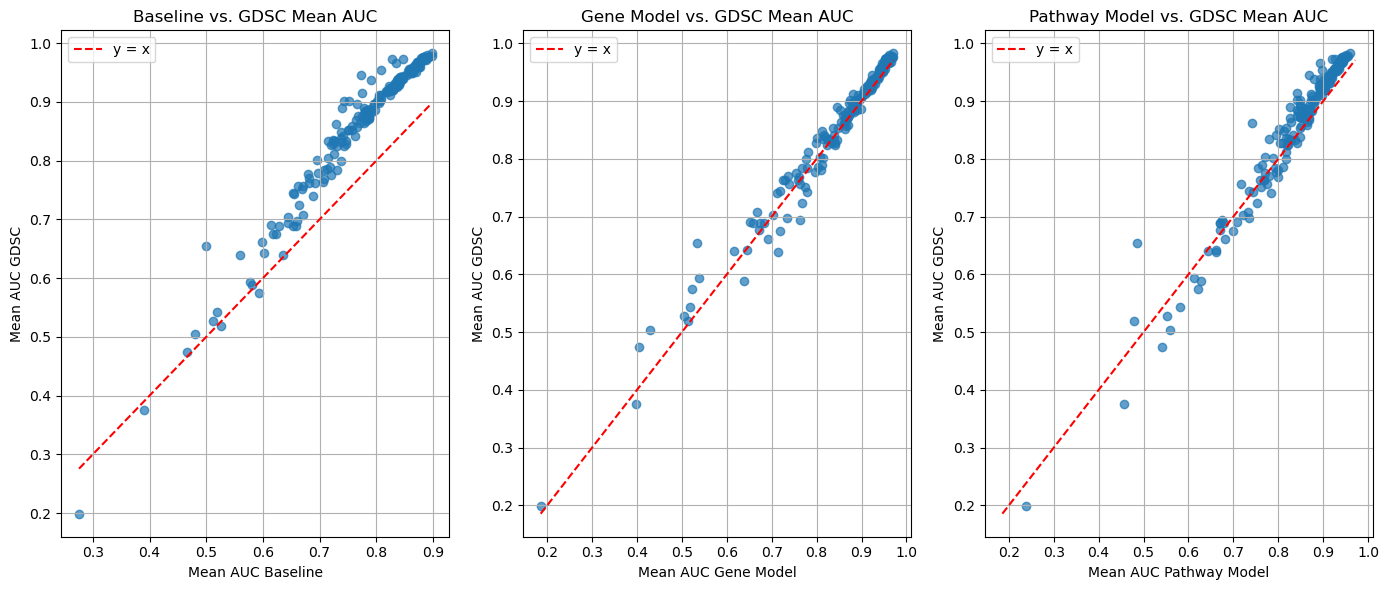

In [98]:
import matplotlib.pyplot as plt

# Gemeinsame Drogen finden (Index-Schnittmenge)
common_drugs_baseline = means_baseline.index.intersection(means_drugs.index)
common_drugs_gene = means_gene.index.intersection(means_drugs.index)
common_drugs_pathways = means_pathway.index.intersection(means_drugs.index)


# Werte extrahieren
x1 = means_baseline[common_drugs_baseline]
y1 = means_drugs[common_drugs_baseline]

x2 = means_gene[common_drugs_gene]
y2 = means_drugs[common_drugs_gene]

x3 = means_pathway[common_drugs_pathways]
y3 = means_drugs[common_drugs_pathways]



# Plot
fig, axes = plt.subplots(1, 3, figsize=(14, 6))

# Plot 1: Baseline vs GDSC
axes[0].scatter(x1, y1, alpha=0.7)
axes[0].plot([x1.min(), x1.max()], [x1.min(), x1.max()], 'r--', label='y = x')
axes[0].set_title('Baseline vs. GDSC Mean AUC')
axes[0].set_xlabel('Mean AUC Baseline')
axes[0].set_ylabel('Mean AUC GDSC')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Gene vs GDSC
axes[1].scatter(x2, y2, alpha=0.7)
axes[1].plot([x2.min(), x2.max()], [x2.min(), x2.max()], 'r--', label='y = x')
axes[1].set_title('Gene Model vs. GDSC Mean AUC')
axes[1].set_xlabel('Mean AUC Gene Model')
axes[1].set_ylabel('Mean AUC GDSC')
axes[1].legend()
axes[1].grid(True)

# Plot 3: Gene vs GDSC
axes[2].scatter(x3, y3, alpha=0.7)
axes[2].plot([x2.min(), x2.max()], [x2.min(), x2.max()], 'r--', label='y = x')
axes[2].set_title('Pathway Model vs. GDSC Mean AUC')
axes[2].set_xlabel('Mean AUC Pathway Model')
axes[2].set_ylabel('Mean AUC GDSC')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()



In [18]:
from sklearn.metrics import mean_absolute_error, r2_score

# Nur gemeinsame Drogen verwenden
common = means_gene.index.intersection(means_drugs.index)
true_vals = means_drugs[common]
pred_gene = means_gene[common]
pred_base = means_baseline[common]

# MAE
mae_gene = mean_absolute_error(true_vals, pred_gene)
mae_base = mean_absolute_error(true_vals, pred_base)

# R²
r2_gene = r2_score(true_vals, pred_gene)
r2_base = r2_score(true_vals, pred_base)

print(f"Gene Model: MAE = {mae_gene:.3f}, R² = {r2_gene:.3f}")
print(f"Baseline Model: MAE = {mae_base:.3f}, R² = {r2_base:.3f}")



Gene Model: MAE = 0.015, R² = 0.969
Baseline Model: MAE = 0.089, R² = 0.442


Baseline Model:

- Im Durchschnitt zeigt das Modell eine Abweichung von 0.089 zum tatsächlichen AUC Wert
- 44,2% der Varianz wird erklärt 

Gene Model:

- Im Durchschnitt zeigt das Modell eine Abweichung von 0.015 zum tatsächlichen AUC Wert
- 99,6% der Varianz wird erklärt 

Je größer der Prozentsatz, der durch das Regressionsmodell erklärt wird, desto näher liegen die Datenpunkte an der angepassten Regressionslinie. Wenn ein Modell theoretisch 100 % der Streuung erklären könnte, wären die angepassten Werte immer gleich den beobachteten Werten, und daher würden alle Datenpunkte auf der angepassten Regressionslinie liegen.

In [99]:
# Schritt 2: Gemeinsamen DataFrame erstellen
df_means = pd.concat([means_baseline, means_gene, means_pathway, means_drugs], axis=1)
df_means.columns = ['baseline', 'gene','pathway', 'gdsc']

# Schritt 3: Zeilen mit NaNs entfernen (falls nötig)
df_means = df_means.dropna()

# Schritt 4: Korrelation berechnen
correlation_matrix = df_means.corr()
print(correlation_matrix)

          baseline      gene   pathway      gdsc
baseline  1.000000  0.971523  0.979900  0.980654
gene      0.971523  1.000000  0.974949  0.987511
pathway   0.979900  0.974949  1.000000  0.979742
gdsc      0.980654  0.987511  0.979742  1.000000


Ein Medikament mit höherer vorhergesagter AUC hat (also geringere Empfindlichkeit / weniger Wirkung), dann zeigt auch die Realität (GDSC-Daten) tendenziell eine höhere AUC für dieses Drug.

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

# --- Lade Daten ---
preds_AUC_gene = pd.read_csv('./results/DA/preds_AUC_naiv_gene_level.csv', index_col=0)
preds_AUC_baseline = pd.read_csv('./results/DA/preds_AUC.csv', index_col=0)
preds_AUC_pathway = pd.read_csv('./results/DA/preds_AUC_naiv_pathway_level.csv', index_col=0)

pdx_dataset = pd.read_csv('./data/PDX_MTL_DA.csv', index_col=0)
drugs_pdx = pdx_dataset.iloc[:, -12:]

# --- Gemeinsame Indizes finden ---
common_index = (
    preds_AUC_baseline.index
    .intersection(preds_AUC_gene.index)
    .intersection(preds_AUC_pathway.index)
    .intersection(drugs_pdx.index)
)

# --- Daten auf gemeinsame Indizes beschränken ---
preds_AUC_baseline = preds_AUC_baseline.loc[common_index]
preds_AUC_gene = preds_AUC_gene.loc[common_index]
preds_AUC_pathway = preds_AUC_pathway.loc[common_index]
drugs_pdx = drugs_pdx.loc[common_index]

# --- Ergebnisse sammeln ---
results = {
    'baseline': {},
    'naive_gene': {},
    'naive_pathway': {}
}

# --- Für jedes Medikament Korrelation berechnen ---
for drug in drugs_pdx.columns:
    y_true = drugs_pdx[drug]
    valid_idx = ~y_true.isna()
    
    if sum(valid_idx) < 2:
        results['baseline'][drug] = float('nan')
        results['naive_gene'][drug] = float('nan')
        results['naive_pathway'][drug] = float('nan')
        continue

    y_true_valid = y_true[valid_idx]
    
    # Baseline
    y_pred_baseline_valid = preds_AUC_baseline.loc[valid_idx, drug]
    if y_pred_baseline_valid.nunique() == 1:
        results['baseline'][drug] = float('nan')
    else:
        corr_baseline, _ = spearmanr(y_true_valid, y_pred_baseline_valid)
        results['baseline'][drug] = corr_baseline

    # Naive Gene-Level
    y_pred_naive_gene_valid = preds_AUC_gene.loc[valid_idx, drug]
    if y_pred_naive_gene_valid.nunique() == 1:
        results['naive_gene'][drug] = float('nan')
    else:
        corr_naive_gene, _ = spearmanr(y_true_valid, y_pred_naive_gene_valid)
        results['naive_gene'][drug] = corr_naive_gene

    # Naive Pathway-Level
    y_pred_naive_pathway_valid = preds_AUC_pathway.loc[valid_idx, drug]
    if y_pred_naive_pathway_valid.nunique() == 1:
        results['naive_pathway'][drug] = float('nan')
    else:
        corr_naive_pathway, _ = spearmanr(y_true_valid, y_pred_naive_pathway_valid)
        results['naive_pathway'][drug] = corr_naive_pathway

# --- In DataFrame konvertieren ---
results_df = pd.DataFrame(results)

# Optional: Ergebnisse speichern
# results_df.to_csv('./results/DA/correlation_results.csv')


                baseline  naive_gene  naive_pathway
Erlotinib       0.639231    0.156154       0.603846
Cetuximab       0.400756    0.233548       0.379067
Gemcitabine     0.029412    0.256022       0.414846
Afatinib        0.396159    0.298483       0.474870
Paclitaxel      0.253758   -0.161391       0.323160
5-Fluorouracil  0.205052    0.236237       0.152439
Trametinib     -0.002371   -0.195590       0.089616
Buparlisib      0.205649    0.020111       0.040593
Ruxolitinib    -0.137492   -0.088263      -0.159993
Tamoxifen       0.146296   -0.137105       0.201007
Alpelisib       0.323570    0.163646       0.267206
LGK974          0.132992   -0.009719       0.162294


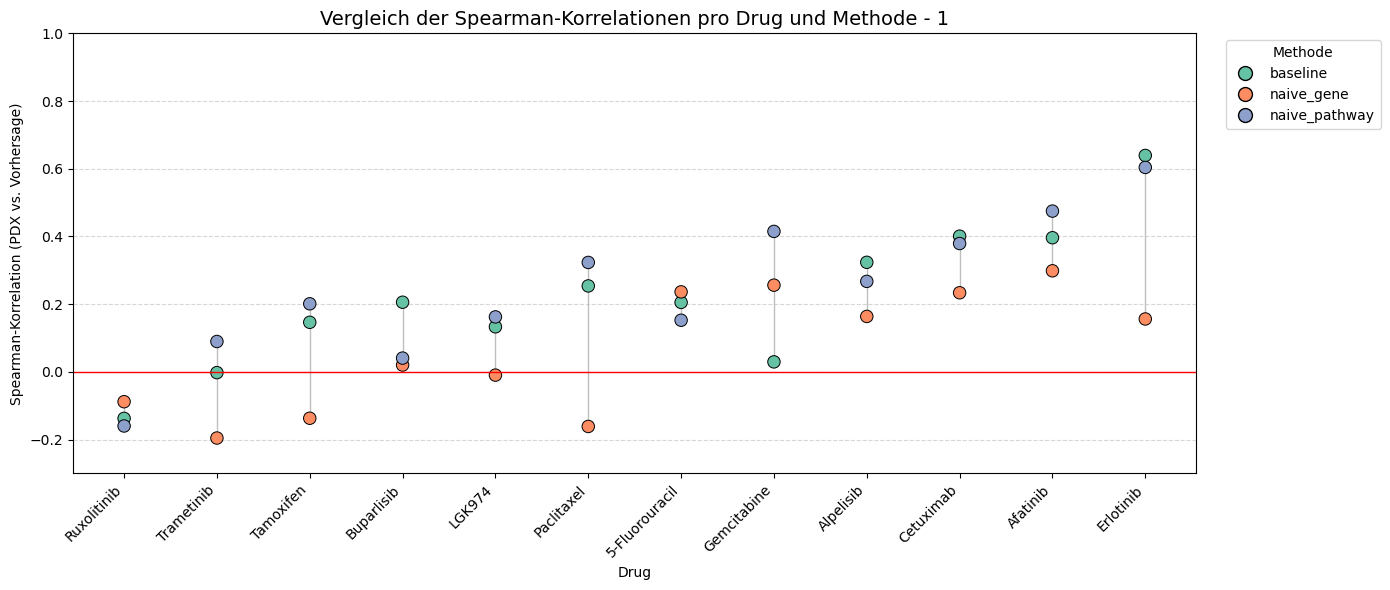

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Daten vorbereiten ---
results_melted = results_df.reset_index().melt(id_vars='index', 
                                                var_name='Methode', 
                                                value_name='Spearman-Korrelation')
results_melted.rename(columns={'index': 'Drug'}, inplace=True)

# --- Sortierung nach Mittelwert (optional für bessere Lesbarkeit) ---
drug_order = results_df.mean(axis=1).sort_values().index.tolist()
method_order = ['baseline', 'naive_gene', 'naive_pathway']

# --- Plot erstellen ---
plt.figure(figsize=(14, 6))

# Punkte + vertikale Verbindungslinien je Drug
for drug in drug_order:
    subset = results_melted[results_melted['Drug'] == drug]
    x_pos = [drug] * len(subset)
    y_vals = subset['Spearman-Korrelation'].values
    methods = subset['Methode'].values
    
    # Vertikale Linie von min bis max
    if len(y_vals) > 1:
        plt.plot([drug, drug], [np.min(y_vals), np.max(y_vals)],
                 color='gray', linewidth=1, alpha=0.5, zorder=1)

    # Punkte (farbig nach Methode)
    sns.scatterplot(x=x_pos,
                    y=y_vals,
                    hue=methods,
                    palette='Set2',
                    s=80,
                    edgecolor='black',
                    legend=False,
                    zorder=2)

# --- Hintergrundlinie bei 0 ---
plt.axhline(0, color='red', linestyle='-', linewidth=1)

# --- Plot-Einstellungen ---
plt.xticks(rotation=45, ha='right')
plt.ylabel('Spearman-Korrelation (PDX vs. Vorhersage)')
plt.xlabel('Drug')
plt.ylim(-0.3, 1.0)
plt.title('Vergleich der Spearman-Korrelationen pro Drug und Methode - 1', fontsize=14)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

# --- Saubere Legende generieren (einmalig aus allen Methoden) ---
from matplotlib.lines import Line2D
method_colors = sns.color_palette('Set2', n_colors=3)
custom_lines = [Line2D([0], [0], marker='o', color='w', markerfacecolor=col,
                       markersize=10, markeredgecolor='black') for col in method_colors]
plt.legend(custom_lines, method_order, title='Methode',
           bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()





- baseline: 4 mal am besten
- naive_gene: 2 mal am besten
- naive_pathway: 7 mal am besten

- Baseline: bessere Anpassung an neue Domäne (PDX). passt AUC-Niveau bei höheren AUC schlecht an, aber behält richtige Rangordnung der Sensitvität (höhere Spearman-Korrelation mit echtem Drug Response in PDX) 
- Gene: Reproduktion von AUC-Niveaus, gut geeignet, wenn AUCs in neune Zelllinien vorhersagen willst 
- Pathways: Reproduktion von AUC-Niveaus, gut geeignet, wenn AUCs in neune Zelllinien vorhersagen willst, aber auch bei Anpassung gut geeignet 

- Wie stark und in welche Richtung der Zusammenhang zwischen den vorhergesagten AUC-Werten (Drug Sensitivity) und den tatsächlichen Labels (aus dem PDX-Datensatz) ist 

### Analysis different thresholds

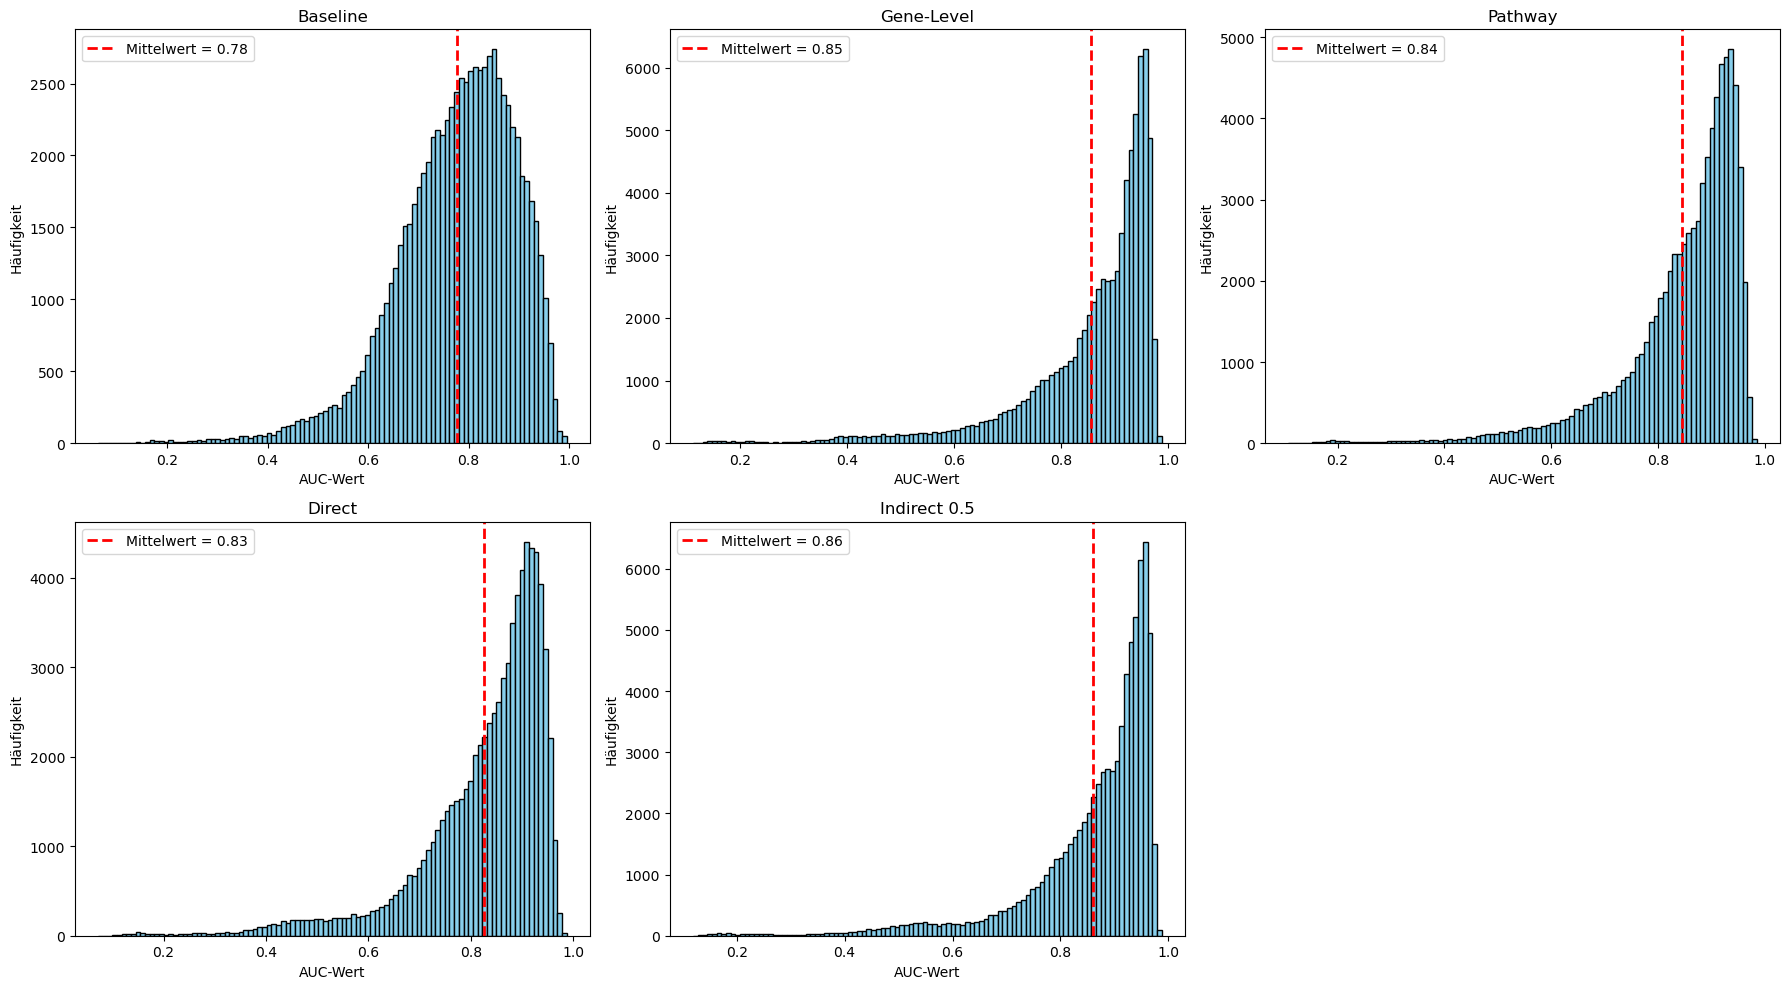

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Lade alle CSV-Dateien
file_paths = {
    'Baseline': './results/DA/preds_AUC.csv',
    'Gene-Level': './results/DA/preds_AUC_naiv_gene_level.csv',
    'Pathway': './results/DA/preds_AUC_naiv_pathway_level.csv',
    'Direct': './results/DA/preds_AUC_direct.csv',
    'Indirect 0.5': './results/DA/preds_AUC_indirect_05.csv',
}

# Lese alle Daten ein
data_dict = {}
for label, path in file_paths.items():
    df = pd.read_csv(path, index_col=0)
    data_dict[label] = df.values.flatten()

# Erzeuge dynamisch genügend Subplots (z. B. 3 Spalten pro Zeile)
num_plots = len(data_dict)
cols = 3
rows = (num_plots + cols - 1) // cols  # Aufteilen auf Zeilen

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 5))
axes = axes.flatten()  # Einfacheres Handling als 1D-Array

# Plotte jedes Dataset in einen Subplot
for i, (label, values) in enumerate(data_dict.items()):
    axes[i].hist(values, bins=100, color='skyblue', edgecolor='black')
    mean_val = np.mean(values)
    axes[i].axvline(x=mean_val, color='red', linestyle='--', linewidth=2,
                    label=f'Mittelwert = {mean_val:.2f}')
    axes[i].set_xlabel('AUC-Wert')
    axes[i].set_ylabel('Häufigkeit')
    axes[i].set_title(label)
    axes[i].legend()

# Leere Subplots ausblenden (falls ungerade Anzahl)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Layout optimieren und anzeigen
plt.tight_layout()
plt.show()

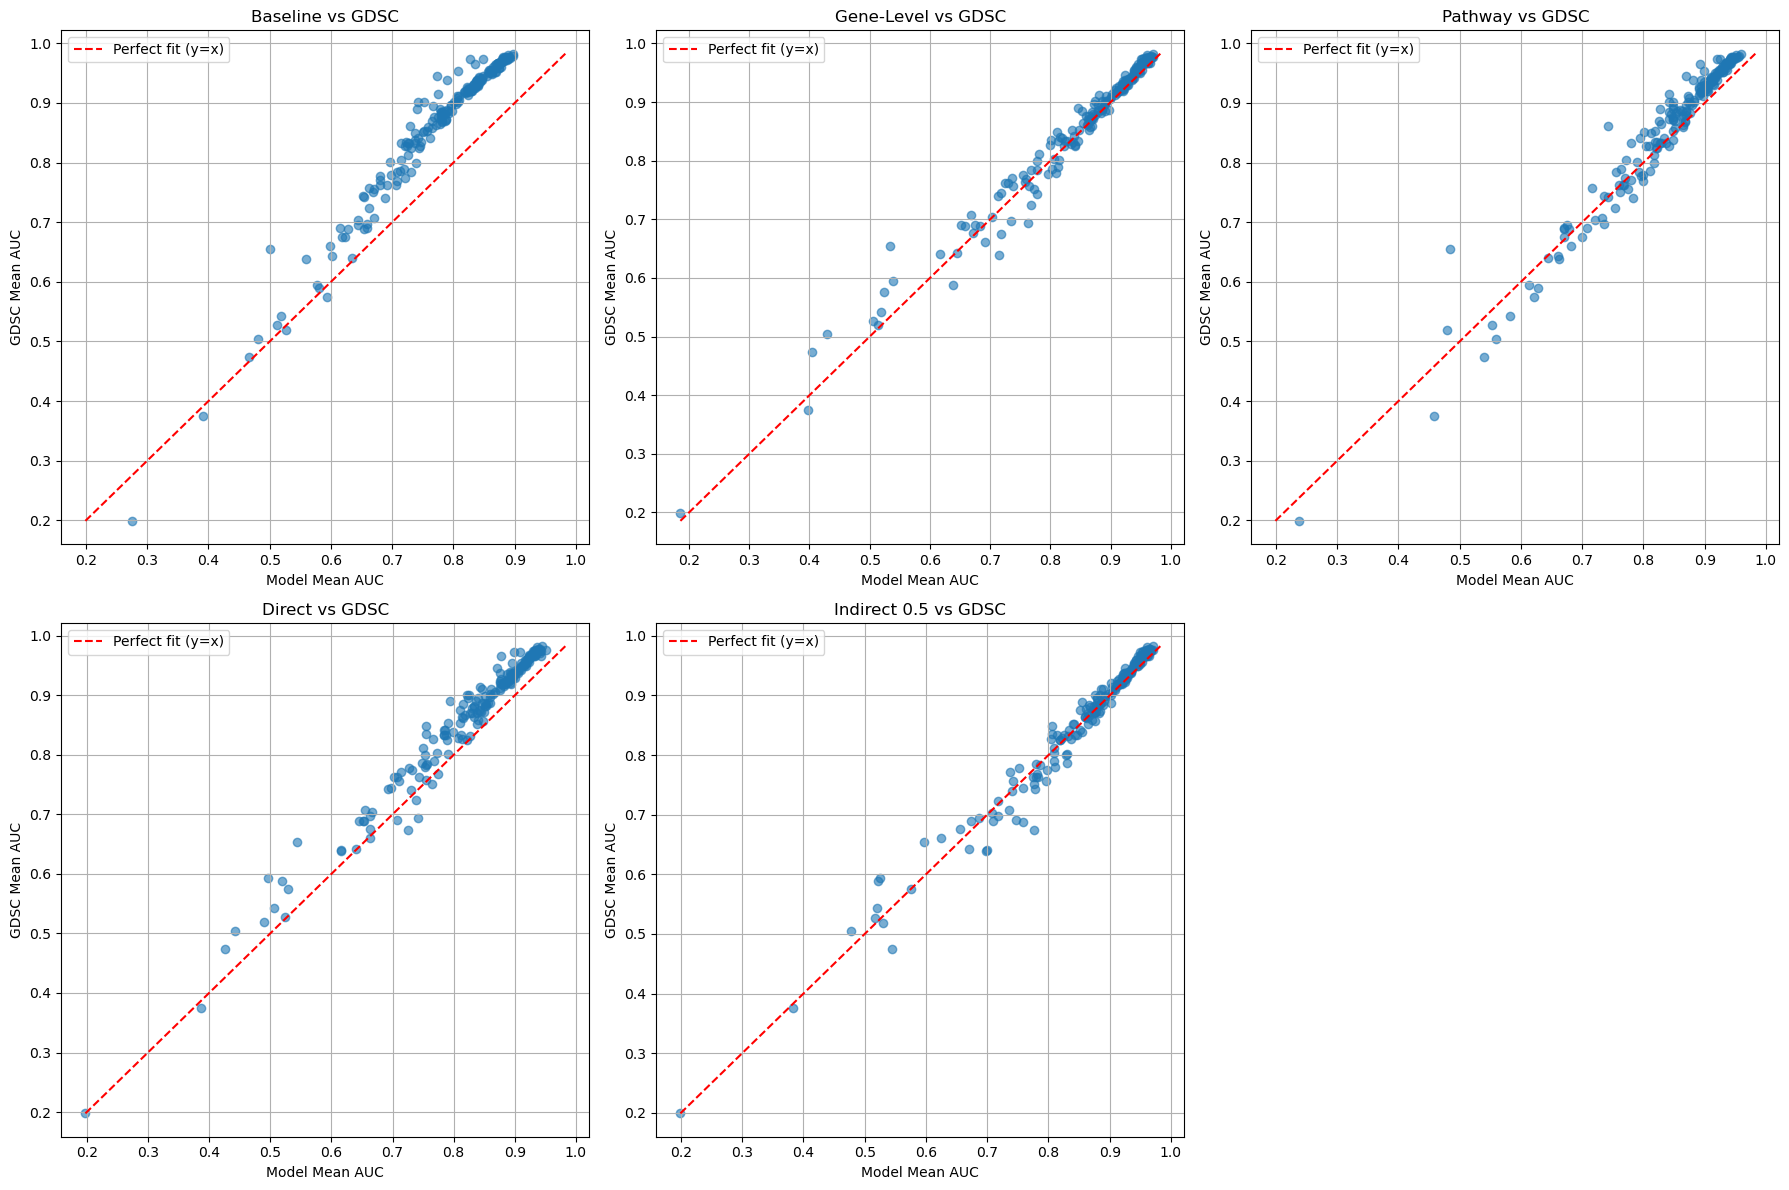

In [8]:
# mean preds_AUC_baseline pro Drug

gdsc_dataset = pd.read_csv('./data/GDSCDA_fpkm_AUC_all_drugs.zip', index_col=0)
gdsc_drugs = gdsc_dataset.iloc[:, -200:]
means_drugs = gdsc_drugs.mean() # NaN values are automatically skipped


# Leere Dictionarys für Mittelwerte
model_means = {}

# Lies alle Modelldateien und berechne Mittelwerte pro Spalte
for label, path in file_paths.items():
    df = pd.read_csv(path, index_col=0)
    model_means[label] = df.mean(axis=0)  # Mittelwert pro Drug

# Finde gemeinsame Drugs zwischen jedem Modell und GDSC
common_drugs_dict = {
    label: mean.index.intersection(means_drugs.index)
    for label, mean in model_means.items()
}

# Erzeuge Scatterplots für jedes Modell
num_models = len(model_means)
cols = 3
rows = (num_models + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 6))
axes = axes.flatten()

for i, (label, means_model) in enumerate(model_means.items()):
    common_drugs = common_drugs_dict[label]
    x = means_model[common_drugs]
    y = means_drugs[common_drugs]

    axes[i].scatter(x, y, alpha=0.6)
    min_val = min(x.min(), y.min())
    max_val = max(x.max(), y.max())
    axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect fit (y=x)')
    axes[i].set_title(f'{label} vs GDSC')
    axes[i].set_xlabel('Model Mean AUC')
    axes[i].set_ylabel('GDSC Mean AUC')
    axes[i].legend()
    axes[i].grid(True)

# Entferne leere Subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [9]:
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd

# Angenommen: means_drugs und model_means sind bereits definiert (wie oben)
# gemeinse Drogen für jedes Modell finden
common_drugs_dict = {
    label: means_model.index.intersection(means_drugs.index)
    for label, means_model in model_means.items()
}

# Leeres Dictionary für Ergebnisse
results = {}

for label, means_model in model_means.items():
    common = common_drugs_dict[label]
    y_true = means_drugs[common]
    y_pred = means_model[common]

    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    results[label] = {
        'MAE': mae,
        'R²': r2
    }

# Umwandeln in DataFrame für bessere Darstellung
results_df = pd.DataFrame(results).T  # Transponieren für bessere Lesbarkeit
print(results_df)

                   MAE        R²
Baseline      0.088825  0.441643
Gene-Level    0.015329  0.969435
Pathway       0.027946  0.926543
Direct        0.039902  0.876695
Indirect 0.5  0.014223  0.972742


In [10]:
results_df

,MAE,R²
Baseline,0.088825,0.441643
Gene-Level,0.015329,0.969435
Pathway,0.027946,0.926543
Direct,0.039902,0.876695
Indirect 0.5,0.014223,0.972742


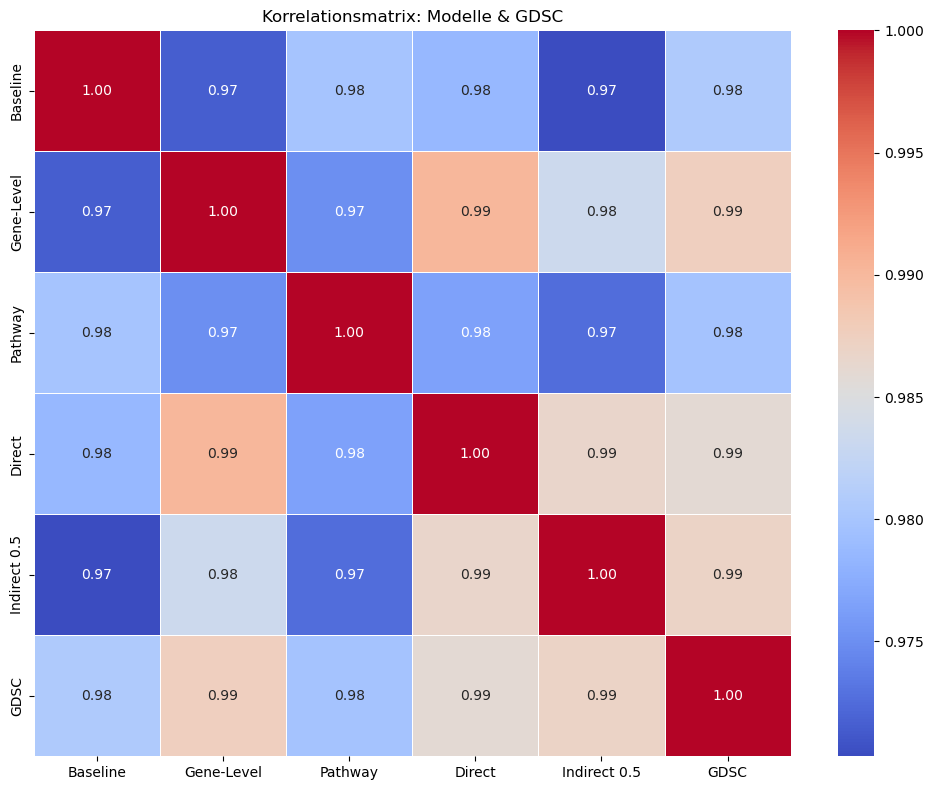

In [11]:
# Zusammengesetzter DataFrame mit allen Modellen + GDSC
all_models_means = pd.DataFrame(model_means)  # model_means ist aus vorherigem Code

# Gemeinsame Drogen mit GDSC finden
common_drugs_all = all_models_means.index.intersection(means_drugs.index)

# Nur gemeinsame Drogen behalten
all_models_common = all_models_means.loc[common_drugs_all]
gdsc_common = means_drugs.loc[common_drugs_all]

# GDSC als zusätzliche Spalte hinzufügen
all_models_common['GDSC'] = gdsc_common

# NaNs entfernen (optional, je nach Daten)
all_models_common = all_models_common.dropna()

correlation_matrix = all_models_common.corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Korrelationsmatrix: Modelle & GDSC')
plt.tight_layout()
plt.show()

In [12]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

# --- 1. Lade PDX Daten ---
pdx_dataset = pd.read_csv('./data/PDX_MTL_DA.csv', index_col=0)
drugs_pdx = pdx_dataset.iloc[:, -12:]  # Letzte 12 Spalten sind die Drogen

# --- 2. Definiere alle Modelldateien ---
file_paths = {
    'Baseline': './results/DA/preds_AUC.csv',
    'Gene-Level': './results/DA/preds_AUC_naiv_gene_level.csv',
    'Pathway-Level': './results/DA/preds_AUC_naiv_pathway_level.csv',
    'Direct': './results/DA/preds_AUC_direct.csv',
    'Indirect 0.5': './results/DA/preds_AUC_indirect_05.csv',
}

# --- 3. Lade alle Modelldateien und finde gemeinsame Indizes ---
model_data = {}

common_index = drugs_pdx.index  # Start mit PDX-Indizes

for label, path in file_paths.items():
    df = pd.read_csv(path, index_col=0)
    model_data[label] = df
    common_index = common_index.intersection(df.index)

# --- 4. Beschränke alle auf gemeinsame Indizes ---
drugs_pdx_common = drugs_pdx.loc[common_index]

model_data_common = {
    label: df.loc[common_index]
    for label, df in model_data.items()
}

# --- 5. Ergebnis-Dictionary initialisieren ---
results = {label: {} for label in model_data_common.keys()}

# --- 6. Spearman pro Drug & Modell berechnen ---
for drug in drugs_pdx_common.columns:
    y_true = drugs_pdx_common[drug]
    valid_idx = ~y_true.isna()

    if sum(valid_idx) < 2:
        for label in results:
            results[label][drug] = float('nan')
        continue

    y_true_valid = y_true[valid_idx]

    for label, df_pred in model_data_common.items():
        y_pred_valid = df_pred.loc[valid_idx, drug]

        if y_pred_valid.nunique() == 1:
            results[label][drug] = float('nan')
        else:
            corr, _ = spearmanr(y_true_valid, y_pred_valid)
            results[label][drug] = corr

# --- 7. In DataFrame konvertieren ---
results_df = pd.DataFrame(results)

In [13]:
results_df

,Baseline,Gene-Level,Pathway-Level,Direct,Indirect 0.5
Erlotinib,0.639231,0.156154,0.603846,0.501538,0.176923
Cetuximab,0.400756,0.233548,0.379067,0.380841,0.252356
Gemcitabine,0.029412,0.256022,0.414846,0.327731,0.259944
Afatinib,0.396159,0.298483,0.474870,0.435514,0.320768
Paclitaxel,0.253758,-0.161391,0.323160,0.096673,-0.131525
5-Fluorouracil,0.205052,0.236237,0.152439,0.301220,0.272474
Trametinib,-0.002371,-0.195590,0.089616,-0.076339,-0.158606
Buparlisib,0.205649,0.020111,0.040593,0.121128,0.032545
Ruxolitinib,-0.137492,-0.088263,-0.159993,-0.116197,-0.047954
Tamoxifen,0.146296,-0.137105,0.201007,0.107123,-0.067294


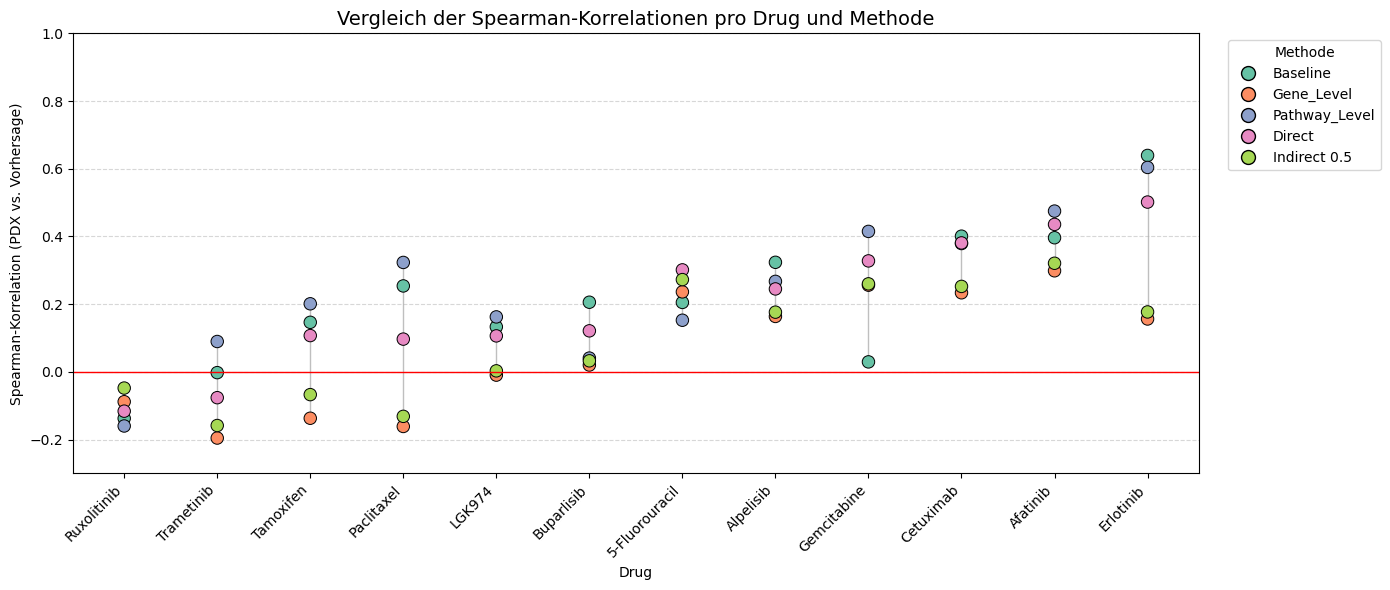

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Daten vorbereiten ---
results_melted = results_df.reset_index().melt(id_vars='index', 
                                                var_name='Methode', 
                                                value_name='Spearman-Korrelation')
results_melted.rename(columns={'index': 'Drug'}, inplace=True)

# --- Sortierung nach Mittelwert (optional für bessere Lesbarkeit) ---
drug_order = results_df.mean(axis=1).sort_values().index.tolist()
method_order = ['Baseline', 'Gene_Level', 'Pathway_Level', 'Direct', 'Indirect 0.5']

# --- Plot erstellen ---
plt.figure(figsize=(14, 6))

# Punkte + vertikale Verbindungslinien je Drug
for drug in drug_order:
    subset = results_melted[results_melted['Drug'] == drug]
    x_pos = [drug] * len(subset)
    y_vals = subset['Spearman-Korrelation'].values
    methods = subset['Methode'].values
    
    # Vertikale Linie von min bis max
    if len(y_vals) > 1:
        plt.plot([drug, drug], [np.min(y_vals), np.max(y_vals)],
                 color='gray', linewidth=1, alpha=0.5, zorder=1)

    # Punkte (farbig nach Methode)
    sns.scatterplot(x=x_pos,
                    y=y_vals,
                    hue=methods,
                    palette='Set2',
                    s=80,
                    edgecolor='black',
                    legend=False,
                    zorder=2)

# --- Hintergrundlinie bei 0 ---
plt.axhline(0, color='red', linestyle='-', linewidth=1)

# --- Plot-Einstellungen ---
plt.xticks(rotation=45, ha='right')
plt.ylabel('Spearman-Korrelation (PDX vs. Vorhersage)')
plt.xlabel('Drug')
plt.ylim(-0.3, 1.0)
plt.title('Vergleich der Spearman-Korrelationen pro Drug und Methode', fontsize=14)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

# --- Saubere Legende generieren (einmalig aus allen Methoden) ---
from matplotlib.lines import Line2D
method_colors = sns.color_palette('Set2', n_colors=10)
custom_lines = [Line2D([0], [0], marker='o', color='w', markerfacecolor=col,
                       markersize=10, markeredgecolor='black') for col in method_colors]
plt.legend(custom_lines, method_order, title='Methode',
           bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()


### Analysis with other Pathway Matrix

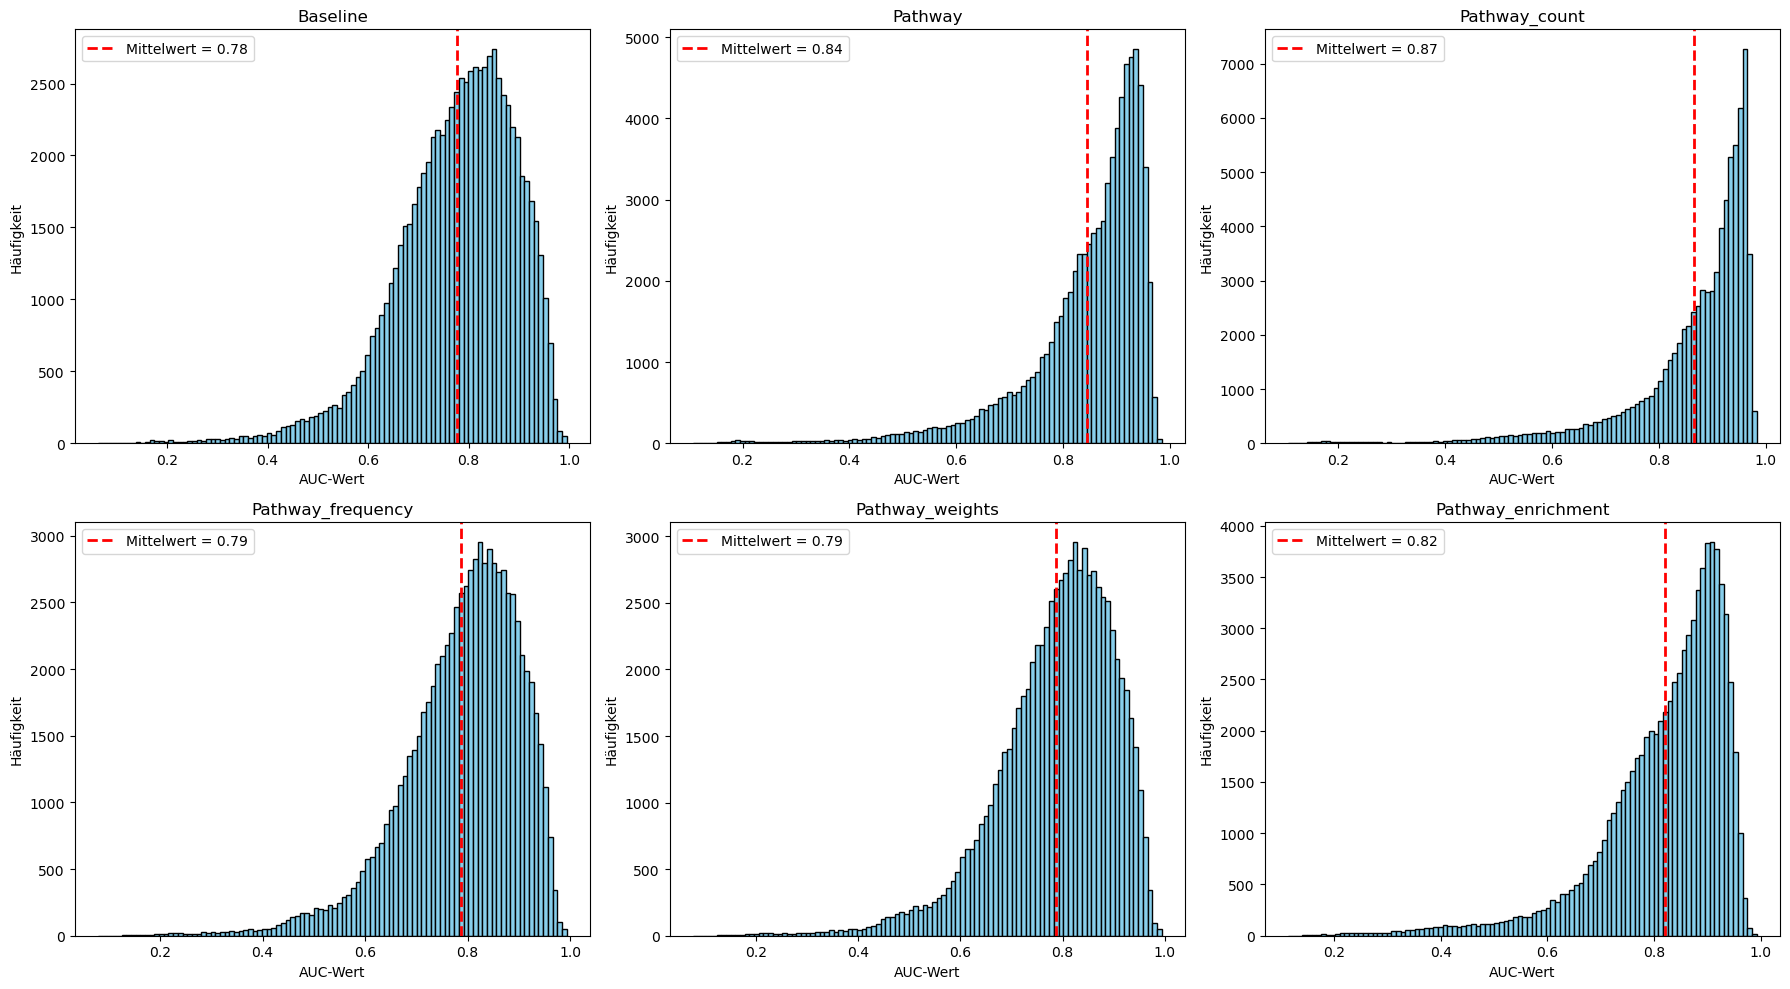

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Lade alle CSV-Dateien
file_paths = {
    'Baseline': './results/DA/preds_AUC.csv',
    'Pathway': './results/DA/preds_AUC_naiv_pathway_level.csv',
    'Pathway_count': './results/DA/preds_AUC_pathway_count.csv',
    'Pathway_frequency': './results/DA/preds_AUC_pathway_frequency.csv',
    'Pathway_weights': './results/DA/preds_AUC_pathway_weights.csv',
    'Pathway_enrichment': './results/DA/preds_AUC_pathway_enrichment.csv'
}

# Lese alle Daten ein
data_dict = {}
for label, path in file_paths.items():
    df = pd.read_csv(path, index_col=0)
    data_dict[label] = df.values.flatten()

# Erzeuge dynamisch genügend Subplots (z. B. 3 Spalten pro Zeile)
num_plots = len(data_dict)
cols = 3
rows = (num_plots + cols - 1) // cols  # Aufteilen auf Zeilen

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 5))
axes = axes.flatten()  # Einfacheres Handling als 1D-Array

# Plotte jedes Dataset in einen Subplot
for i, (label, values) in enumerate(data_dict.items()):
    axes[i].hist(values, bins=100, color='skyblue', edgecolor='black')
    mean_val = np.mean(values)
    axes[i].axvline(x=mean_val, color='red', linestyle='--', linewidth=2,
                    label=f'Mittelwert = {mean_val:.2f}')
    axes[i].set_xlabel('AUC-Wert')
    axes[i].set_ylabel('Häufigkeit')
    axes[i].set_title(label)
    axes[i].legend()

# Leere Subplots ausblenden (falls ungerade Anzahl)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Layout optimieren und anzeigen
plt.tight_layout()
plt.show()

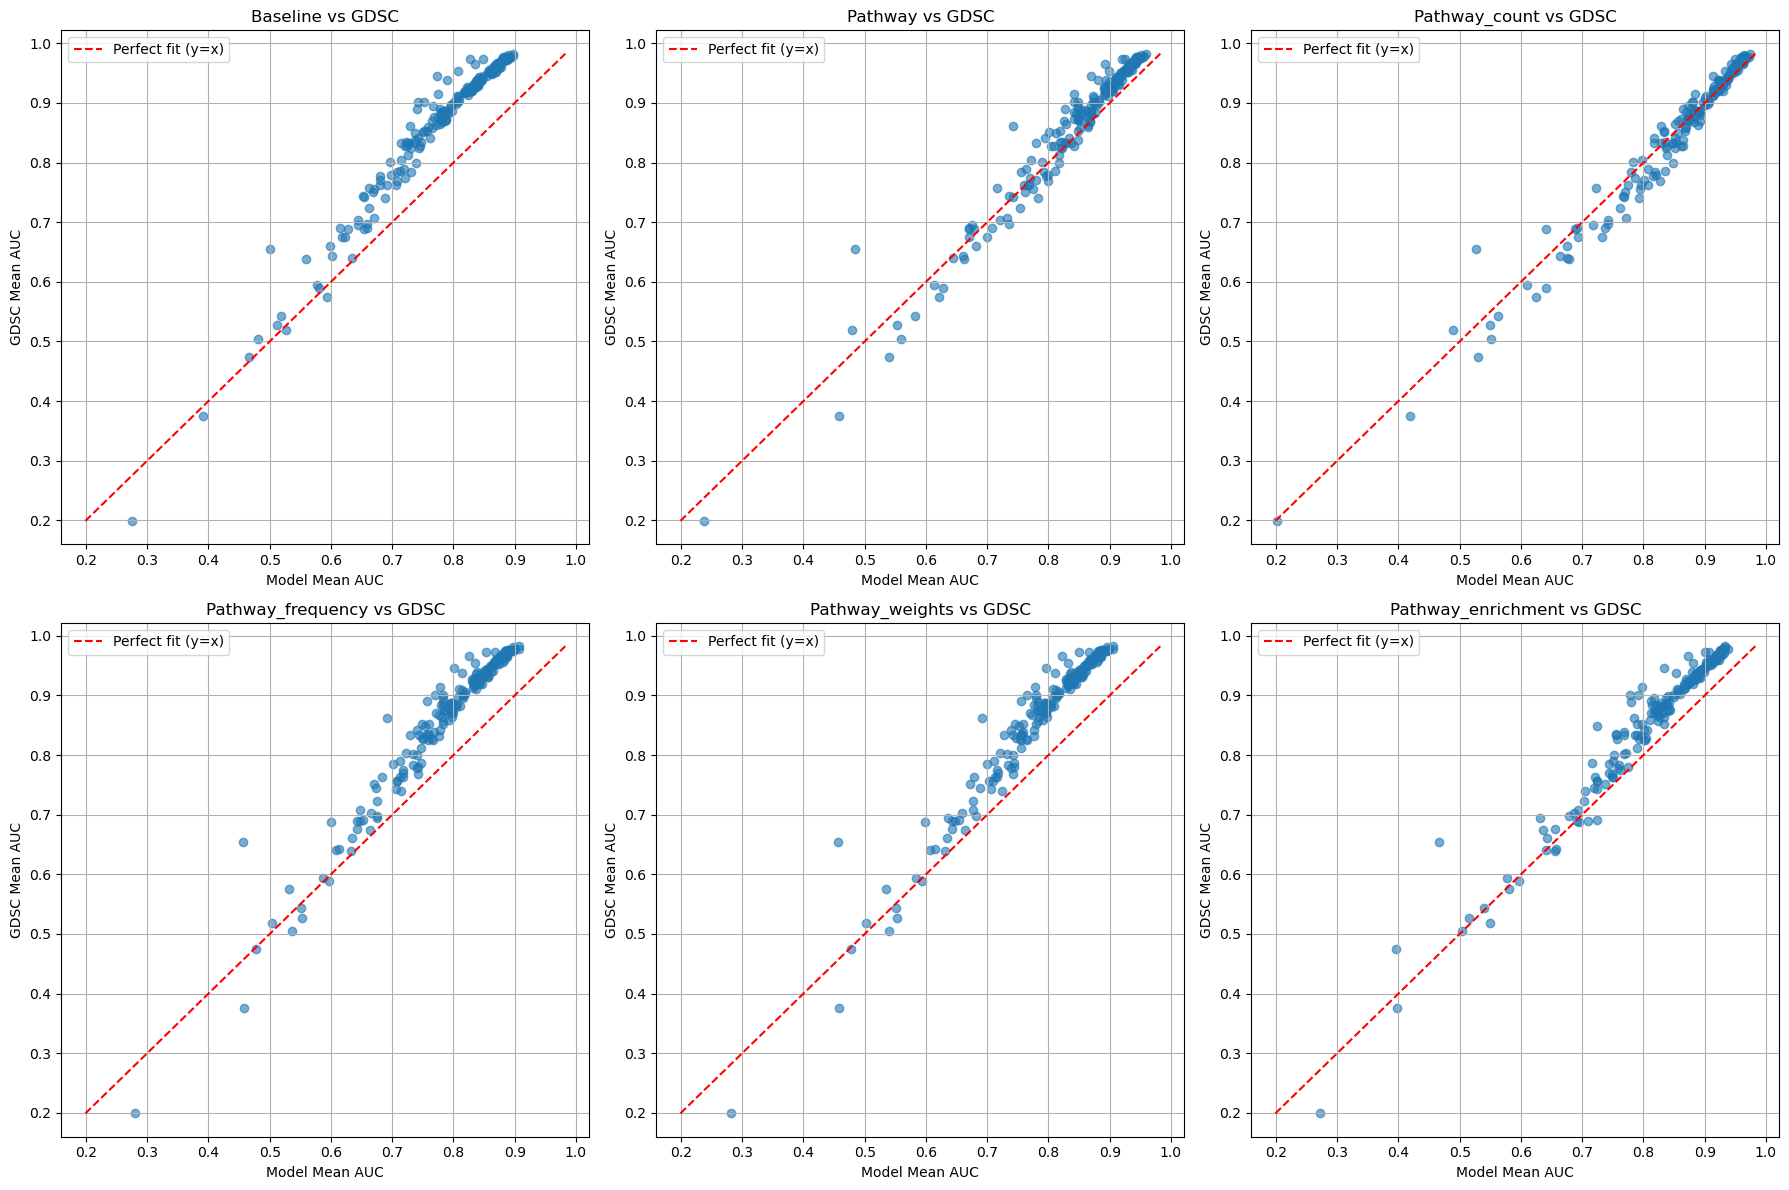

In [22]:
# mean preds_AUC_baseline pro Drug

gdsc_dataset = pd.read_csv('./data/GDSCDA_fpkm_AUC_all_drugs.zip', index_col=0)
gdsc_drugs = gdsc_dataset.iloc[:, -200:]
means_drugs = gdsc_drugs.mean() # NaN values are automatically skipped


# Leere Dictionarys für Mittelwerte
model_means = {}

# Lies alle Modelldateien und berechne Mittelwerte pro Spalte
for label, path in file_paths.items():
    df = pd.read_csv(path, index_col=0)
    model_means[label] = df.mean(axis=0)  # Mittelwert pro Drug

# Finde gemeinsame Drugs zwischen jedem Modell und GDSC
common_drugs_dict = {
    label: mean.index.intersection(means_drugs.index)
    for label, mean in model_means.items()
}

# Erzeuge Scatterplots für jedes Modell
num_models = len(model_means)
cols = 3
rows = (num_models + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 6))
axes = axes.flatten()

for i, (label, means_model) in enumerate(model_means.items()):
    common_drugs = common_drugs_dict[label]
    x = means_model[common_drugs]
    y = means_drugs[common_drugs]

    axes[i].scatter(x, y, alpha=0.6)
    min_val = min(x.min(), y.min())
    max_val = max(x.max(), y.max())
    axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect fit (y=x)')
    axes[i].set_title(f'{label} vs GDSC')
    axes[i].set_xlabel('Model Mean AUC')
    axes[i].set_ylabel('GDSC Mean AUC')
    axes[i].legend()
    axes[i].grid(True)

# Entferne leere Subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


- beides reinnehmen 
- Overfitting

In [23]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

# --- 1. Lade PDX Daten ---
pdx_dataset = pd.read_csv('./data/PDX_MTL_DA.csv', index_col=0)
drugs_pdx = pdx_dataset.iloc[:, -12:]  # Letzte 12 Spalten sind die Drogen

# --- 2. Definiere alle Modelldateien ---
file_paths = {
    'Baseline': './results/DA/preds_AUC.csv',
    'Pathway': './results/DA/preds_AUC_naiv_pathway_level.csv',
    'Pathway_count': './results/DA/preds_AUC_pathway_count.csv',
    'Pathway_frequency': './results/DA/preds_AUC_pathway_frequency.csv',
    'Pathway_weights': './results/DA/preds_AUC_pathway_weights.csv',
    'Pathway_enrichment': './results/DA/preds_AUC_pathway_enrichment.csv'
}

# --- 3. Lade alle Modelldateien und finde gemeinsame Indizes ---
model_data = {}

common_index = drugs_pdx.index  # Start mit PDX-Indizes

for label, path in file_paths.items():
    df = pd.read_csv(path, index_col=0)
    model_data[label] = df
    common_index = common_index.intersection(df.index)

# --- 4. Beschränke alle auf gemeinsame Indizes ---
drugs_pdx_common = drugs_pdx.loc[common_index]

model_data_common = {
    label: df.loc[common_index]
    for label, df in model_data.items()
}

# --- 5. Ergebnis-Dictionary initialisieren ---
results = {label: {} for label in model_data_common.keys()}

# --- 6. Spearman pro Drug & Modell berechnen ---
for drug in drugs_pdx_common.columns:
    y_true = drugs_pdx_common[drug]
    valid_idx = ~y_true.isna()

    if sum(valid_idx) < 2:
        for label in results:
            results[label][drug] = float('nan')
        continue

    y_true_valid = y_true[valid_idx]

    for label, df_pred in model_data_common.items():
        y_pred_valid = df_pred.loc[valid_idx, drug]

        if y_pred_valid.nunique() == 1:
            results[label][drug] = float('nan')
        else:
            corr, _ = spearmanr(y_true_valid, y_pred_valid)
            results[label][drug] = corr

# --- 7. In DataFrame konvertieren ---
results_df = pd.DataFrame(results)

In [24]:
results_df

,Baseline,Pathway,Pathway_count,Pathway_frequency,Pathway_weights,Pathway_enrichment
Erlotinib,0.639231,0.603846,0.343846,0.645385,0.625385,0.572308
Cetuximab,0.400756,0.379067,0.336837,0.339133,0.329906,0.385141
Gemcitabine,0.029412,0.414846,0.400560,0.208964,0.227451,0.454062
Afatinib,0.396159,0.474870,0.325510,0.443101,0.435989,0.475581
Paclitaxel,0.253758,0.323160,0.075067,0.284279,0.283977,0.144721
5-Fluorouracil,0.205052,0.152439,0.109756,0.195122,0.206272,0.162021
Trametinib,-0.002371,0.089616,-0.017307,0.144855,0.161214,0.065434
Buparlisib,0.205649,0.040593,-0.067178,0.194571,0.195970,0.100573
Ruxolitinib,-0.137492,-0.159993,-0.153588,-0.129309,-0.128940,-0.099598
Tamoxifen,0.146296,0.201007,-0.047598,0.128132,0.126600,0.037094


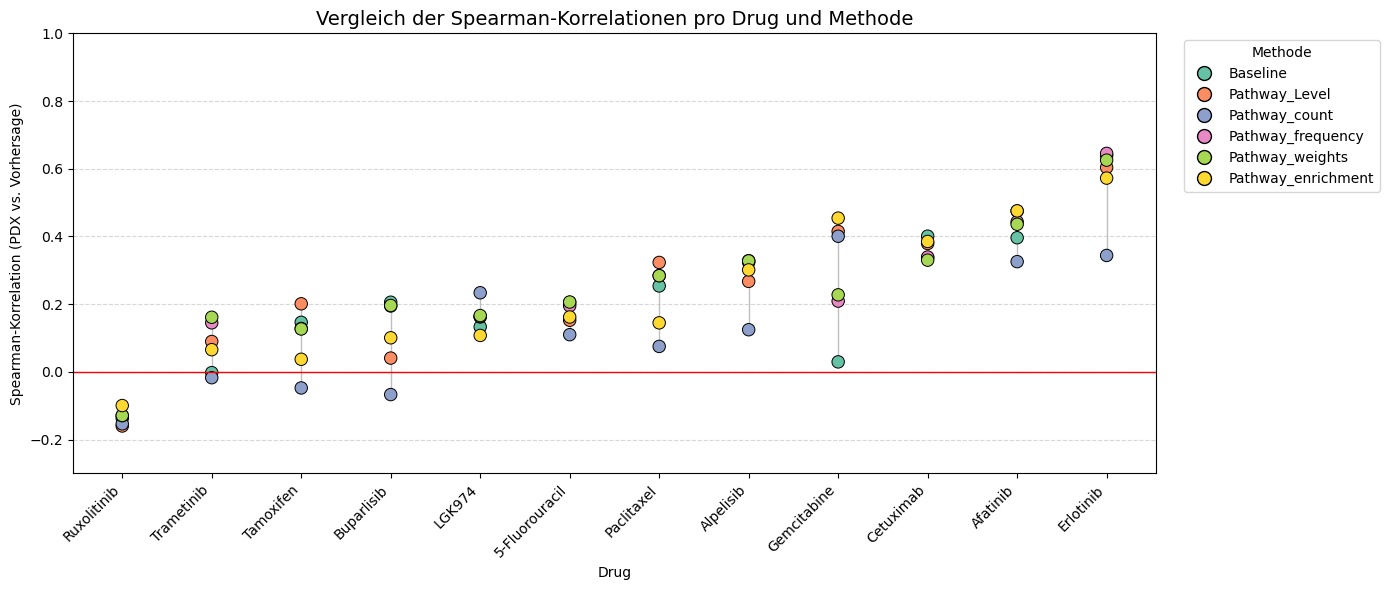

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Daten vorbereiten ---
results_melted = results_df.reset_index().melt(id_vars='index', 
                                                var_name='Methode', 
                                                value_name='Spearman-Korrelation')
results_melted.rename(columns={'index': 'Drug'}, inplace=True)

# --- Sortierung nach Mittelwert (optional für bessere Lesbarkeit) ---
drug_order = results_df.mean(axis=1).sort_values().index.tolist()
method_order = ['Baseline','Pathway_Level', 'Pathway_count', 'Pathway_frequency', 'Pathway_weights', 'Pathway_enrichment']

# --- Plot erstellen ---
plt.figure(figsize=(14, 6))

# Punkte + vertikale Verbindungslinien je Drug
for drug in drug_order:
    subset = results_melted[results_melted['Drug'] == drug]
    x_pos = [drug] * len(subset)
    y_vals = subset['Spearman-Korrelation'].values
    methods = subset['Methode'].values
    
    # Vertikale Linie von min bis max
    if len(y_vals) > 1:
        plt.plot([drug, drug], [np.min(y_vals), np.max(y_vals)],
                 color='gray', linewidth=1, alpha=0.5, zorder=1)

    # Punkte (farbig nach Methode)
    sns.scatterplot(x=x_pos,
                    y=y_vals,
                    hue=methods,
                    palette='Set2',
                    s=80,
                    edgecolor='black',
                    legend=False,
                    zorder=2)

# --- Hintergrundlinie bei 0 ---
plt.axhline(0, color='red', linestyle='-', linewidth=1)

# --- Plot-Einstellungen ---
plt.xticks(rotation=45, ha='right')
plt.ylabel('Spearman-Korrelation (PDX vs. Vorhersage)')
plt.xlabel('Drug')
plt.ylim(-0.3, 1.0)
plt.title('Vergleich der Spearman-Korrelationen pro Drug und Methode', fontsize=14)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

# --- Saubere Legende generieren (einmalig aus allen Methoden) ---
from matplotlib.lines import Line2D
method_colors = sns.color_palette('Set2', n_colors=10)
custom_lines = [Line2D([0], [0], marker='o', color='w', markerfacecolor=col,
                       markersize=10, markeredgecolor='black') for col in method_colors]
plt.legend(custom_lines, method_order, title='Methode',
           bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

### Analysis for each Cancer Type (Baseline Modell)

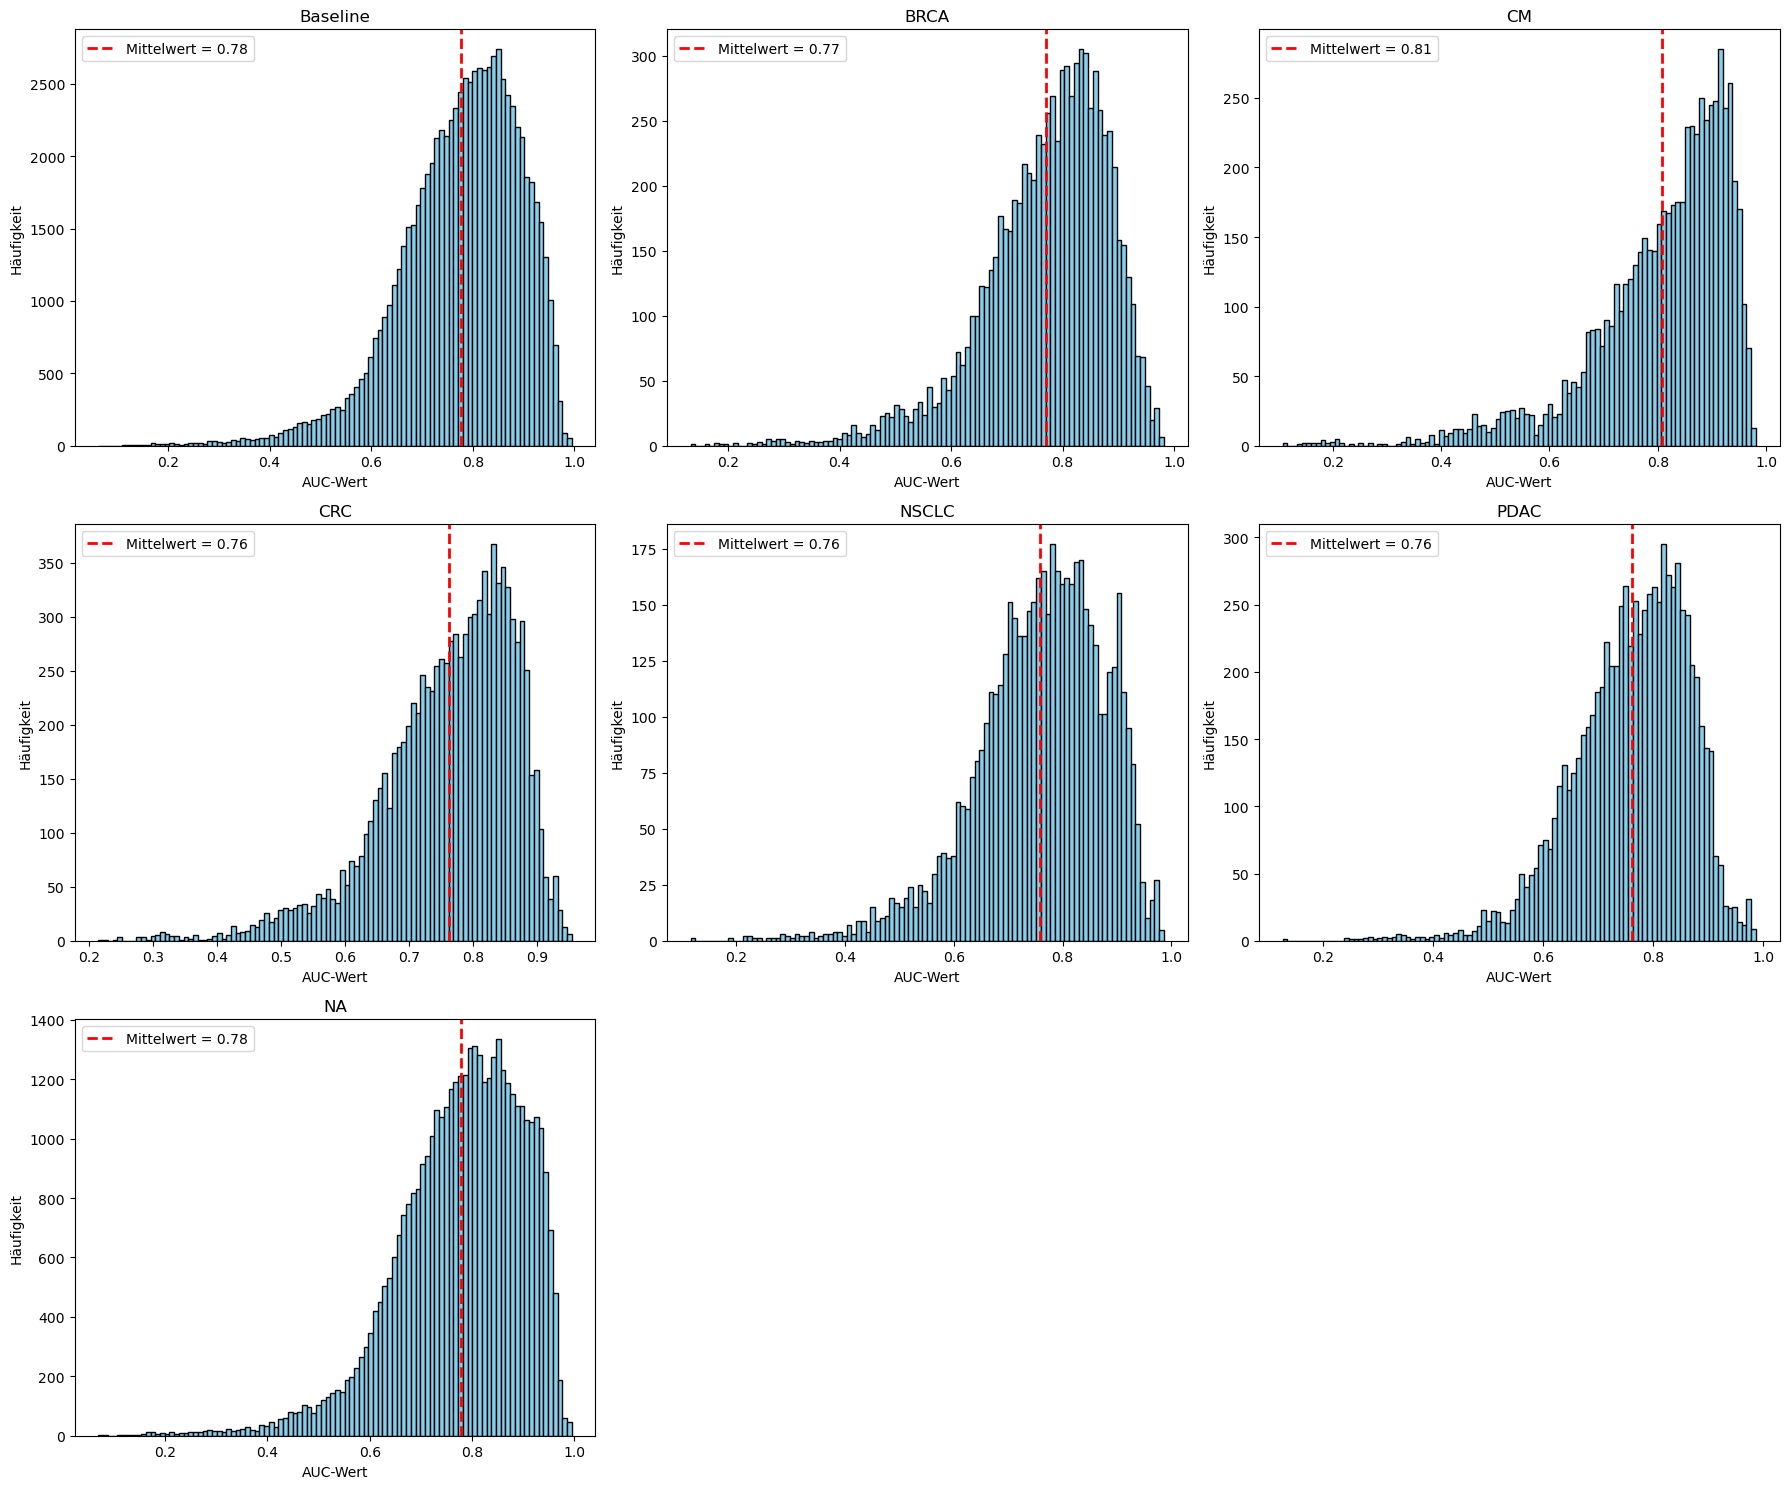

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Lade alle CSV-Dateien
file_paths = {
    'Baseline': './results/DA/preds_AUC.csv',
    'BRCA': './results/DA/preds_AUC_BRCA.csv',
    'CM': './results/DA/preds_AUC_CM.csv',
    'CRC': './results/DA/preds_AUC_CRC.csv',
    'NSCLC': './results/DA/preds_AUC_NSCLC.csv',
    'PDAC': './results/DA/preds_AUC_PDAC.csv',
    'NA': './results/DA/preds_AUC_NA.csv'
}

# Lese alle Daten ein
data_dict = {}
for label, path in file_paths.items():
    df = pd.read_csv(path, index_col=0)
    data_dict[label] = df.values.flatten()

# Erzeuge dynamisch genügend Subplots (z. B. 3 Spalten pro Zeile)
num_plots = len(data_dict)
cols = 3
rows = (num_plots + cols - 1) // cols  # Aufteilen auf Zeilen

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 5))
axes = axes.flatten()  # Einfacheres Handling als 1D-Array

# Plotte jedes Dataset in einen Subplot
for i, (label, values) in enumerate(data_dict.items()):
    axes[i].hist(values, bins=100, color='skyblue', edgecolor='black')
    mean_val = np.mean(values)
    axes[i].axvline(x=mean_val, color='red', linestyle='--', linewidth=2,
                    label=f'Mittelwert = {mean_val:.2f}')
    axes[i].set_xlabel('AUC-Wert')
    axes[i].set_ylabel('Häufigkeit')
    axes[i].set_title(label)
    axes[i].legend()

# Leere Subplots ausblenden (falls ungerade Anzahl)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Layout optimieren und anzeigen
plt.tight_layout()
plt.show()

In [43]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

# --- 1. Lade PDX Daten ---
pdx_dataset = pd.read_csv('./data/PDX_MTL_DA.csv', index_col=0)
drugs_pdx = pdx_dataset.iloc[:, -12:]  # Letzte 12 Spalten sind die Drogen

# --- 2. Definiere alle Modelldateien ---
file_paths = {
    'Baseline': './results/DA/preds_AUC.csv',
    'BRCA': './results/DA/preds_AUC_BRCA.csv',
    'CM': './results/DA/preds_AUC_CM.csv',
    'CRC': './results/DA/preds_AUC_CRC.csv',
    'NSCLC': './results/DA/preds_AUC_NSCLC.csv',
    'PDAC': './results/DA/preds_AUC_PDAC.csv',
    'NA': './results/DA/preds_AUC_NA.csv'
}

# --- 3. Ergebnis-Dictionary initialisieren ---
results = {label: {} for label in file_paths.keys()}

# --- 4. Für jedes Modell separat arbeiten ---
for label, path in file_paths.items():
    # Lade Vorhersagen des aktuellen Modells
    df_pred = pd.read_csv(path, index_col=0)

    # Finde übereinstimmende Indizes mit PDX-Daten
    common_index = drugs_pdx.index.intersection(df_pred.index)

    if len(common_index) < 1:
        # Keine gemeinsamen Indizes -> alles NaN
        for drug in drugs_pdx.columns:
            results[label][drug] = float('nan')
        continue

    # Hole die relevanten PDX-Werte
    drugs_pdx_common = drugs_pdx.loc[common_index]
    df_pred_common = df_pred.loc[common_index]

    # Berechne Spearman pro Drug
    for drug in drugs_pdx_common.columns:
        y_true = drugs_pdx_common[drug]
        y_pred = df_pred_common[drug]

        valid_idx = (~y_true.isna()) & (~y_pred.isna())
        y_true_valid = y_true[valid_idx]
        y_pred_valid = y_pred[valid_idx]

        if len(y_true_valid) < 5:  # Mindestens 5 Paare erforderlich
            results[label][drug] = float('nan')
        elif y_true_valid.nunique() < 2 or y_pred_valid.nunique() < 2:
            results[label][drug] = float('nan')
        elif np.std(y_true_valid) < 1e-6 or np.std(y_pred_valid) < 1e-6:
            results[label][drug] = float('nan')
        else:
            corr, _ = spearmanr(y_true_valid, y_pred_valid)
            results[label][drug] = corr

# --- 5. In DataFrame konvertieren ---
results_df = pd.DataFrame(results)

In [44]:
results_df

,Baseline,BRCA,CM,CRC,NSCLC,PDAC,NA
Erlotinib,0.639231,NaN,NaN,NaN,0.651538,NaN,NaN
Cetuximab,0.400756,NaN,NaN,0.393902,0.433077,NaN,NaN
Gemcitabine,0.029412,NaN,NaN,NaN,NaN,0.009015,NaN
Afatinib,0.396159,0.385254,NaN,NaN,NaN,NaN,NaN
Paclitaxel,0.253758,0.086552,NaN,NaN,0.624348,NaN,NaN
5-Fluorouracil,0.205052,NaN,NaN,0.163763,NaN,NaN,NaN
Trametinib,-0.002371,NaN,NaN,NaN,NaN,0.110644,NaN
Buparlisib,0.205649,0.044534,-0.013563,0.311069,0.301538,0.194398,NaN
Ruxolitinib,-0.137492,-0.044808,NaN,NaN,NaN,-0.250668,NaN
Tamoxifen,0.146296,0.103403,NaN,NaN,NaN,NaN,NaN


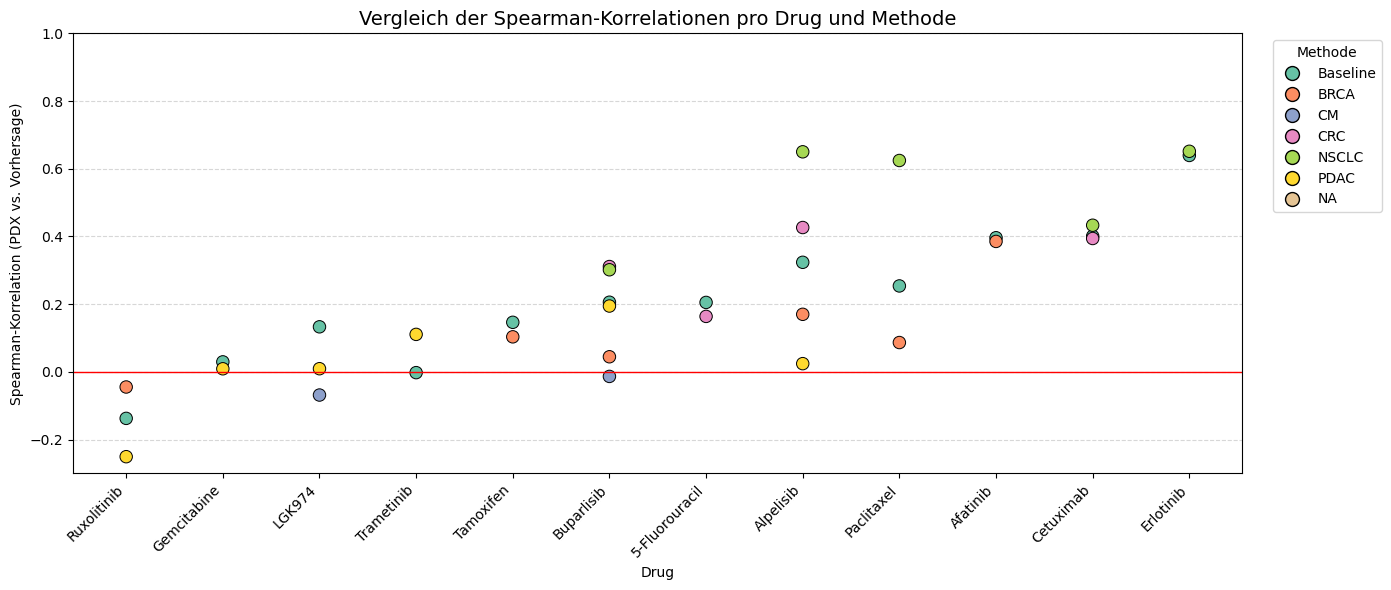

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Daten vorbereiten ---
results_melted = results_df.reset_index().melt(id_vars='index', 
                                                var_name='Methode', 
                                                value_name='Spearman-Korrelation')
results_melted.rename(columns={'index': 'Drug'}, inplace=True)

# --- Sortierung nach Mittelwert (optional für bessere Lesbarkeit) ---
drug_order = results_df.mean(axis=1).sort_values().index.tolist()
method_order = ['Baseline','BRCA', 'CM', 'CRC', 'NSCLC', 'PDAC', 'NA']

# --- Plot erstellen ---
plt.figure(figsize=(14, 6))

# Punkte + vertikale Verbindungslinien je Drug
for drug in drug_order:
    subset = results_melted[results_melted['Drug'] == drug]
    x_pos = [drug] * len(subset)
    y_vals = subset['Spearman-Korrelation'].values
    methods = subset['Methode'].values
    
    # Vertikale Linie von min bis max
    if len(y_vals) > 1:
        plt.plot([drug, drug], [np.min(y_vals), np.max(y_vals)],
                 color='gray', linewidth=1, alpha=0.5, zorder=1)

    # Punkte (farbig nach Methode)
    sns.scatterplot(x=x_pos,
                    y=y_vals,
                    hue=methods,
                    palette='Set2',
                    s=80,
                    edgecolor='black',
                    legend=False,
                    zorder=2)

# --- Hintergrundlinie bei 0 ---
plt.axhline(0, color='red', linestyle='-', linewidth=1)

# --- Plot-Einstellungen ---
plt.xticks(rotation=45, ha='right')
plt.ylabel('Spearman-Korrelation (PDX vs. Vorhersage)')
plt.xlabel('Drug')
plt.ylim(-0.3, 1.0)
plt.title('Vergleich der Spearman-Korrelationen pro Drug und Methode', fontsize=14)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

# --- Saubere Legende generieren (einmalig aus allen Methoden) ---
from matplotlib.lines import Line2D
method_colors = sns.color_palette('Set2', n_colors=10)
custom_lines = [Line2D([0], [0], marker='o', color='w', markerfacecolor=col,
                       markersize=10, markeredgecolor='black') for col in method_colors]
plt.legend(custom_lines, method_order, title='Methode',
           bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

### Analysis for each Cancer Type (Naiv Modell)

#### direct targets

In [55]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

# --- 1. Lade PDX Daten ---
pdx_dataset = pd.read_csv('./data/PDX_MTL_DA.csv', index_col=0)
drugs_pdx = pdx_dataset.iloc[:, -12:]  # Letzte 12 Spalten sind die Drogen

# --- 2. Definiere alle Modelldateien ---
file_paths = {
    'Baseline': './results/DA/preds_AUC.csv',
    'Direct': './results/DA/preds_AUC_direct.csv',
    'BRCA': './results/DA/preds_AUC_direct_BRCA.csv',
    'CM': './results/DA/preds_AUC_direct_CM.csv',
    'CRC': './results/DA/preds_AUC_direct_CRC.csv',
    'NSCLC': './results/DA/preds_AUC_direct_NSCLC.csv',
    'PDAC': './results/DA/preds_AUC_direct_PDAC.csv'
}

# --- 3. Ergebnis-Dictionary initialisieren ---
results = {label: {} for label in file_paths.keys()}

# --- 4. Für jedes Modell separat arbeiten ---
for label, path in file_paths.items():
    # Lade Vorhersagen des aktuellen Modells
    df_pred = pd.read_csv(path, index_col=0)

    # Finde übereinstimmende Indizes mit PDX-Daten
    common_index = drugs_pdx.index.intersection(df_pred.index)

    if len(common_index) < 1:
        # Keine gemeinsamen Indizes -> alles NaN
        for drug in drugs_pdx.columns:
            results[label][drug] = float('nan')
        continue

    # Hole die relevanten PDX-Werte
    drugs_pdx_common = drugs_pdx.loc[common_index]
    df_pred_common = df_pred.loc[common_index]

    # Berechne Spearman pro Drug
    for drug in drugs_pdx_common.columns:
        y_true = drugs_pdx_common[drug]
        y_pred = df_pred_common[drug]

        valid_idx = (~y_true.isna()) & (~y_pred.isna())
        y_true_valid = y_true[valid_idx]
        y_pred_valid = y_pred[valid_idx]

        if len(y_true_valid) < 5:  # Mindestens 5 Paare erforderlich
            results[label][drug] = float('nan')
        elif y_true_valid.nunique() < 2 or y_pred_valid.nunique() < 2:
            results[label][drug] = float('nan')
        elif np.std(y_true_valid) < 1e-6 or np.std(y_pred_valid) < 1e-6:
            results[label][drug] = float('nan')
        else:
            corr, _ = spearmanr(y_true_valid, y_pred_valid)
            results[label][drug] = corr

# --- 5. In DataFrame konvertieren ---
results_df = pd.DataFrame(results)

In [56]:
results_df

,Baseline,Direct,BRCA,CM,CRC,NSCLC,PDAC
Erlotinib,0.639231,0.501538,NaN,NaN,NaN,0.527692,NaN
Cetuximab,0.400756,0.380841,NaN,NaN,0.342160,0.415385,NaN
Gemcitabine,0.029412,0.327731,NaN,NaN,NaN,NaN,0.313063
Afatinib,0.396159,0.435514,0.522523,NaN,NaN,NaN,NaN
Paclitaxel,0.253758,0.096673,0.014991,NaN,NaN,0.318261,NaN
5-Fluorouracil,0.205052,0.301220,NaN,NaN,0.159059,NaN,NaN
Trametinib,-0.002371,-0.076339,NaN,NaN,NaN,NaN,-0.018487
Buparlisib,0.205649,0.121128,-0.104060,0.081745,0.169794,0.209231,0.122409
Ruxolitinib,-0.137492,-0.116197,0.009483,NaN,NaN,NaN,-0.196524
Tamoxifen,0.146296,0.107123,0.209323,NaN,NaN,NaN,NaN


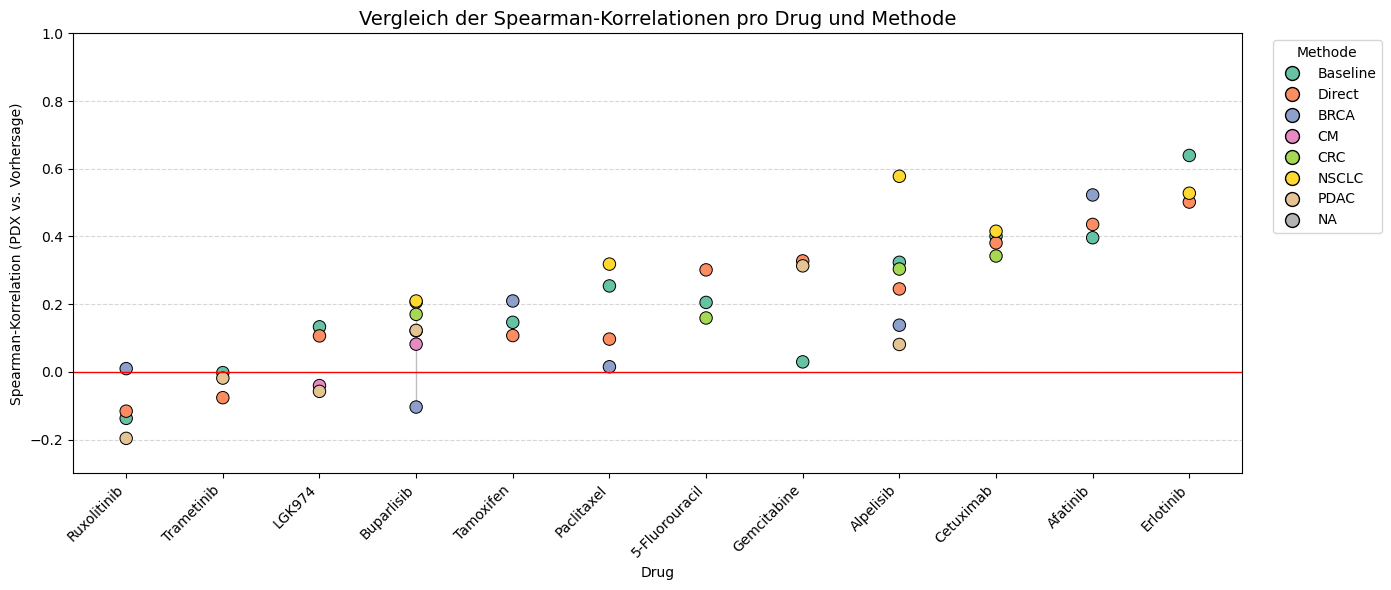

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Daten vorbereiten ---
results_melted = results_df.reset_index().melt(id_vars='index', 
                                                var_name='Methode', 
                                                value_name='Spearman-Korrelation')
results_melted.rename(columns={'index': 'Drug'}, inplace=True)

# --- Sortierung nach Mittelwert (optional für bessere Lesbarkeit) ---
drug_order = results_df.mean(axis=1).sort_values().index.tolist()
method_order = ['Baseline', 'Direct', 'BRCA', 'CM', 'CRC', 'NSCLC', 'PDAC', 'NA']

# --- Plot erstellen ---
plt.figure(figsize=(14, 6))

# Punkte + vertikale Verbindungslinien je Drug
for drug in drug_order:
    subset = results_melted[results_melted['Drug'] == drug]
    x_pos = [drug] * len(subset)
    y_vals = subset['Spearman-Korrelation'].values
    methods = subset['Methode'].values
    
    # Vertikale Linie von min bis max
    if len(y_vals) > 1:
        plt.plot([drug, drug], [np.min(y_vals), np.max(y_vals)],
                 color='gray', linewidth=1, alpha=0.5, zorder=1)

    # Punkte (farbig nach Methode)
    sns.scatterplot(x=x_pos,
                    y=y_vals,
                    hue=methods,
                    palette='Set2',
                    s=80,
                    edgecolor='black',
                    legend=False,
                    zorder=2)

# --- Hintergrundlinie bei 0 ---
plt.axhline(0, color='red', linestyle='-', linewidth=1)

# --- Plot-Einstellungen ---
plt.xticks(rotation=45, ha='right')
plt.ylabel('Spearman-Korrelation (PDX vs. Vorhersage)')
plt.xlabel('Drug')
plt.ylim(-0.3, 1.0)
plt.title('Vergleich der Spearman-Korrelationen pro Drug und Methode', fontsize=14)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

# --- Saubere Legende generieren (einmalig aus allen Methoden) ---
from matplotlib.lines import Line2D
method_colors = sns.color_palette('Set2', n_colors=10)
custom_lines = [Line2D([0], [0], marker='o', color='w', markerfacecolor=col,
                       markersize=10, markeredgecolor='black') for col in method_colors]
plt.legend(custom_lines, method_order, title='Methode',
           bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

#### indirect targets

In [57]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

# --- 1. Lade PDX Daten ---
pdx_dataset = pd.read_csv('./data/PDX_MTL_DA.csv', index_col=0)
drugs_pdx = pdx_dataset.iloc[:, -12:]  # Letzte 12 Spalten sind die Drogen

# --- 2. Definiere alle Modelldateien ---
file_paths = {
    'Baseline': './results/DA/preds_AUC.csv',
    'Indirect 0.5': './results/DA/preds_AUC_indirect_05.csv',
    'BRCA': './results/DA/preds_AUC_indirect_BRCA.csv',
    'CM': './results/DA/preds_AUC_indirect_CM.csv',
    'CRC': './results/DA/preds_AUC_indirect_CRC.csv',
    'NSCLC': './results/DA/preds_AUC_indirect_NSCLC.csv',
    'PDAC': './results/DA/preds_AUC_indirect_PDAC.csv'
}

# --- 3. Ergebnis-Dictionary initialisieren ---
results = {label: {} for label in file_paths.keys()}

# --- 4. Für jedes Modell separat arbeiten ---
for label, path in file_paths.items():
    # Lade Vorhersagen des aktuellen Modells
    df_pred = pd.read_csv(path, index_col=0)

    # Finde übereinstimmende Indizes mit PDX-Daten
    common_index = drugs_pdx.index.intersection(df_pred.index)

    if len(common_index) < 1:
        # Keine gemeinsamen Indizes -> alles NaN
        for drug in drugs_pdx.columns:
            results[label][drug] = float('nan')
        continue

    # Hole die relevanten PDX-Werte
    drugs_pdx_common = drugs_pdx.loc[common_index]
    df_pred_common = df_pred.loc[common_index]

    # Berechne Spearman pro Drug
    for drug in drugs_pdx_common.columns:
        y_true = drugs_pdx_common[drug]
        y_pred = df_pred_common[drug]

        valid_idx = (~y_true.isna()) & (~y_pred.isna())
        y_true_valid = y_true[valid_idx]
        y_pred_valid = y_pred[valid_idx]

        if len(y_true_valid) < 5:  # Mindestens 5 Paare erforderlich
            results[label][drug] = float('nan')
        elif y_true_valid.nunique() < 2 or y_pred_valid.nunique() < 2:
            results[label][drug] = float('nan')
        elif np.std(y_true_valid) < 1e-6 or np.std(y_pred_valid) < 1e-6:
            results[label][drug] = float('nan')
        else:
            corr, _ = spearmanr(y_true_valid, y_pred_valid)
            results[label][drug] = corr

# --- 5. In DataFrame konvertieren ---
results_df = pd.DataFrame(results)

In [58]:
results_df

,Baseline,Indirect 0.5,BRCA,CM,CRC,NSCLC,PDAC
Erlotinib,0.639231,0.176923,NaN,NaN,NaN,0.220000,NaN
Cetuximab,0.400756,0.252356,NaN,NaN,0.125436,0.338462,NaN
Gemcitabine,0.029412,0.259944,NaN,NaN,NaN,NaN,0.434072
Afatinib,0.396159,0.320768,0.525605,NaN,NaN,NaN,NaN
Paclitaxel,0.253758,-0.131525,-0.065106,NaN,NaN,-0.354783,NaN
5-Fluorouracil,0.205052,0.272474,NaN,NaN,0.006272,NaN,NaN
Trametinib,-0.002371,-0.158606,NaN,NaN,NaN,NaN,-0.101961
Buparlisib,0.205649,0.032545,-0.156801,0.075147,-0.010507,-0.094615,0.046218
Ruxolitinib,-0.137492,-0.047954,0.099336,NaN,NaN,NaN,-0.175802
Tamoxifen,0.146296,-0.067294,0.251559,NaN,NaN,NaN,NaN


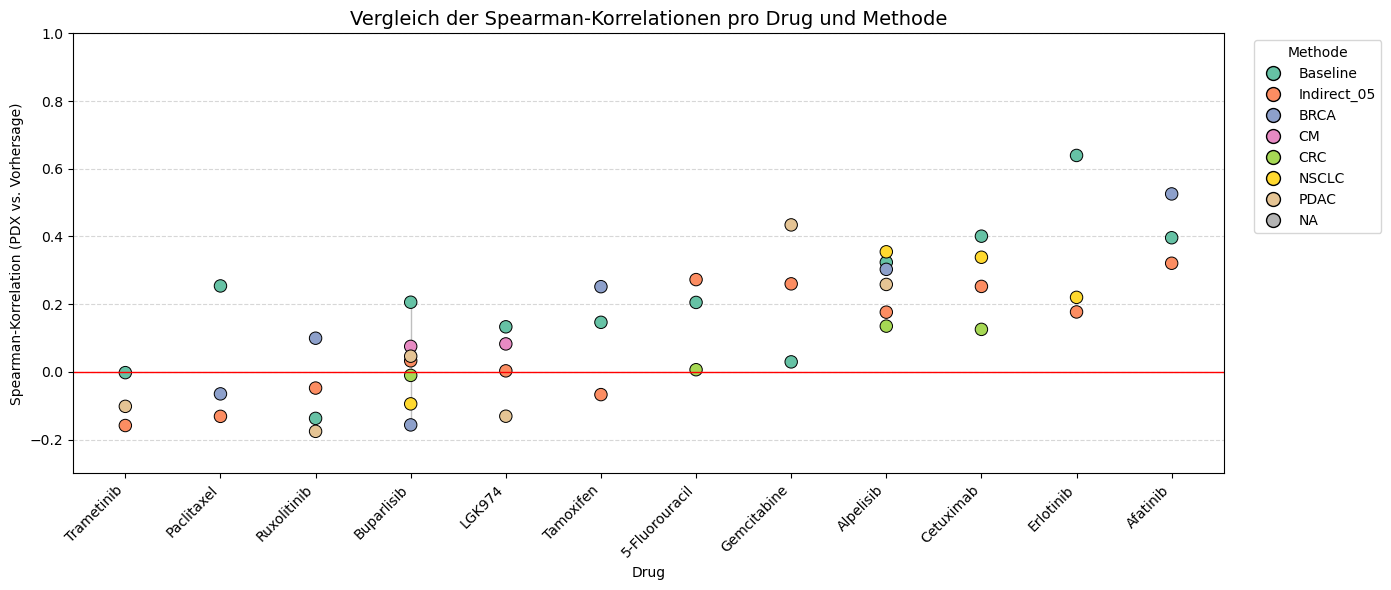

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Daten vorbereiten ---
results_melted = results_df.reset_index().melt(id_vars='index', 
                                                var_name='Methode', 
                                                value_name='Spearman-Korrelation')
results_melted.rename(columns={'index': 'Drug'}, inplace=True)

# --- Sortierung nach Mittelwert (optional für bessere Lesbarkeit) ---
drug_order = results_df.mean(axis=1).sort_values().index.tolist()
method_order = ['Baseline','Indirect_05', 'BRCA', 'CM', 'CRC', 'NSCLC', 'PDAC', 'NA']

# --- Plot erstellen ---
plt.figure(figsize=(14, 6))

# Punkte + vertikale Verbindungslinien je Drug
for drug in drug_order:
    subset = results_melted[results_melted['Drug'] == drug]
    x_pos = [drug] * len(subset)
    y_vals = subset['Spearman-Korrelation'].values
    methods = subset['Methode'].values
    
    # Vertikale Linie von min bis max
    if len(y_vals) > 1:
        plt.plot([drug, drug], [np.min(y_vals), np.max(y_vals)],
                 color='gray', linewidth=1, alpha=0.5, zorder=1)

    # Punkte (farbig nach Methode)
    sns.scatterplot(x=x_pos,
                    y=y_vals,
                    hue=methods,
                    palette='Set2',
                    s=80,
                    edgecolor='black',
                    legend=False,
                    zorder=2)

# --- Hintergrundlinie bei 0 ---
plt.axhline(0, color='red', linestyle='-', linewidth=1)

# --- Plot-Einstellungen ---
plt.xticks(rotation=45, ha='right')
plt.ylabel('Spearman-Korrelation (PDX vs. Vorhersage)')
plt.xlabel('Drug')
plt.ylim(-0.3, 1.0)
plt.title('Vergleich der Spearman-Korrelationen pro Drug und Methode', fontsize=14)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

# --- Saubere Legende generieren (einmalig aus allen Methoden) ---
from matplotlib.lines import Line2D
method_colors = sns.color_palette('Set2', n_colors=10)
custom_lines = [Line2D([0], [0], marker='o', color='w', markerfacecolor=col,
                       markersize=10, markeredgecolor='black') for col in method_colors]
plt.legend(custom_lines, method_order, title='Methode',
           bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

### Interpretation und Diskussion

- Wie oft je das Modell besser performt als die anderen
- Problem bei klinischer Anwendung --> Overfitting?
- Onkopedia 
- Verteilung der Interaktionen

### Pathway, Gene_Interactions

In [20]:
# Gemeinsame Drugs
common_drugs = means_gene.index.intersection(means_baseline.index).intersection(means_drugs.index)

# Fehler berechnen
errors_gene = (means_gene[common_drugs] - means_drugs[common_drugs]).abs()
errors_baseline = (means_baseline[common_drugs] - means_drugs[common_drugs]).abs()

# Differenz der Fehler: positive Werte = Baseline besser
error_diff = errors_gene - errors_baseline

# Drugs mit kleinerem Fehler im Baseline-Modell
baseline_better = error_diff[error_diff > 0].sort_values(ascending=False)

print("📉 Drugs, bei denen das Baseline-Modell besser ist:")
print(baseline_better.head(10))  # Top 10 Fälle



📉 Drugs, bei denen das Baseline-Modell besser ist:
MG-132           0.060960
CDK9_5038        0.050703
Dinaciclib       0.040329
CDK9_5576        0.038792
Sabutoclax       0.033796
GNE-317          0.018127
Daporinad        0.018063
Bleomycin        0.007093
Staurosporine    0.006518
Vinblastine      0.002512
dtype: float64


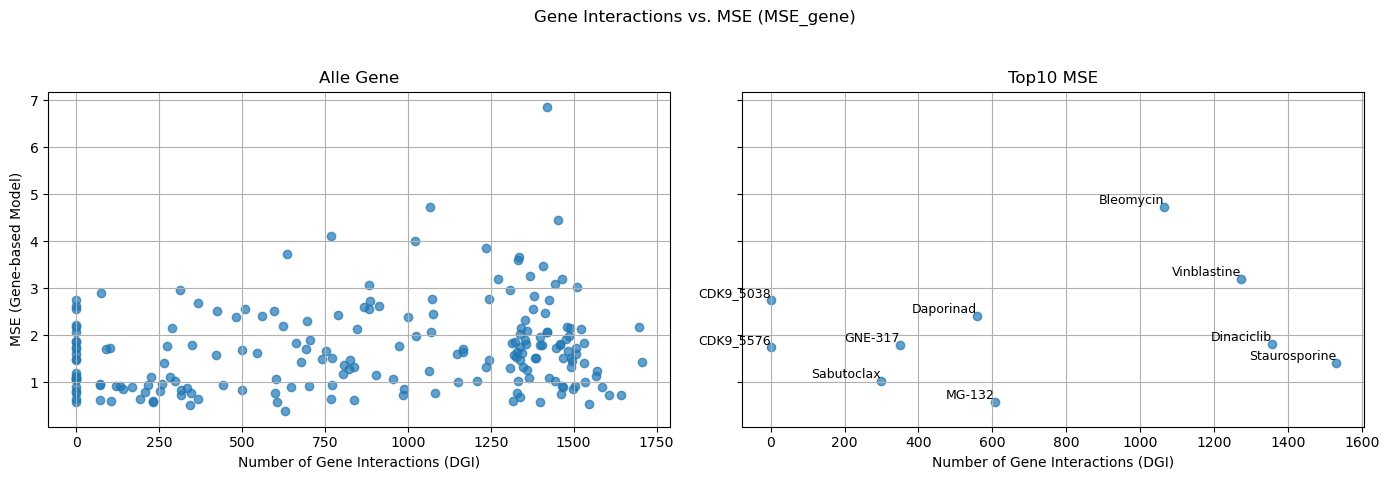

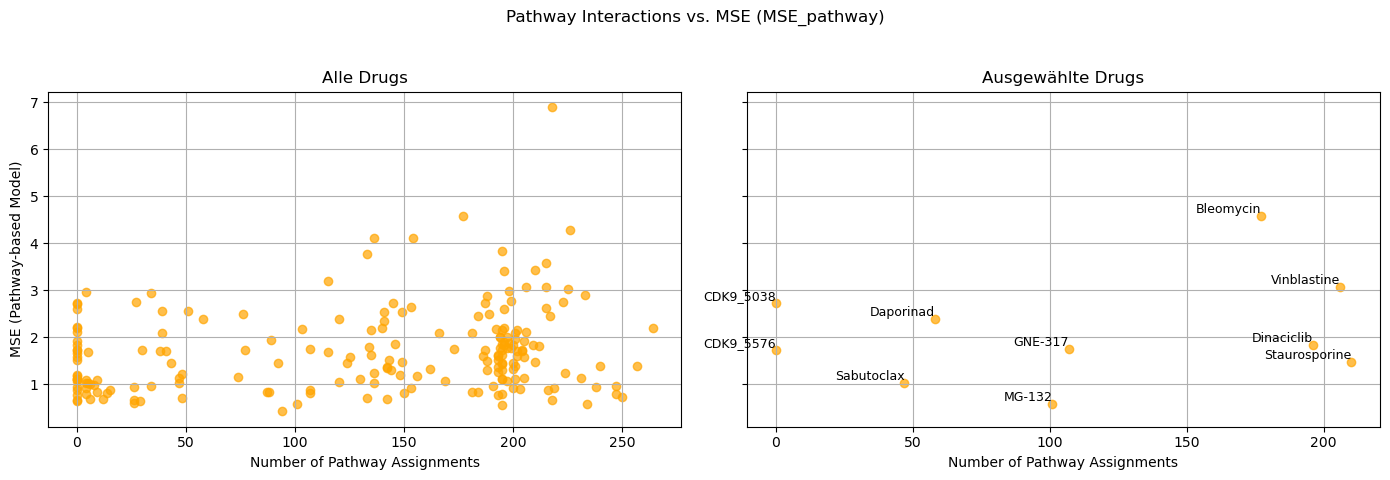

In [33]:
# Erstelle nebeneinanderliegende Subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Liste der gewünschten Drugs
selected_drugs_baseline = baseline_better.head(10).index.tolist()

# Filtere den DataFrame auf diese Drugs
df_selected = df_mse[df_mse.index.isin(selected_drugs_baseline)]


# Plot 1: Alle Daten
axes[0].scatter(df_mse["DGI_interactions"], df_mse["MSE_gene"], alpha=0.7)
axes[0].set_title("Alle Gene")
axes[0].set_xlabel("Number of Gene Interactions (DGI)")
axes[0].set_ylabel("MSE (Gene-based Model)")
axes[0].grid(True)

# Plot 2: Nur ausgewählte Drugs, mit Beschriftung
axes[1].scatter(df_selected["DGI_interactions"], df_selected["MSE_gene"], alpha=0.7)
for idx, row in df_selected.iterrows():
    axes[1].text(row['DGI_interactions'], row['MSE_gene'], str(idx),
                 fontsize=9, ha='right', va='bottom')
axes[1].set_title("Top10 MSE")
axes[1].set_xlabel("Number of Gene Interactions (DGI)")
axes[1].grid(True)

# Layout und Anzeige
plt.suptitle("Gene Interactions vs. MSE (MSE_gene)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Plot 1: Alle Daten
axes[0].scatter(df_mse["Pathway_interactions"], df_mse["MSE_pathway"], alpha=0.7, color="orange")
axes[0].set_title("Alle Drugs")
axes[0].set_xlabel("Number of Pathway Assignments")
axes[0].set_ylabel("MSE (Pathway-based Model)")
axes[0].grid(True)

# Plot 2: Nur ausgewählte Drugs, mit Beschriftung
axes[1].scatter(df_selected["Pathway_interactions"], df_selected["MSE_pathway"], alpha=0.7, color="orange")
for idx, row in df_selected.iterrows():
    axes[1].text(row['Pathway_interactions'], row['MSE_pathway'], str(idx),
                 fontsize=9, ha='right', va='bottom')
axes[1].set_title("Ausgewählte Drugs")
axes[1].set_xlabel("Number of Pathway Assignments")
axes[1].grid(True)

# Layout und Anzeige
plt.suptitle("Pathway Interactions vs. MSE (MSE_pathway)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Um die Interpretierbarkeit des von TUGDA gelernten Merkmalsraums zu untersuchen, haben wir die Gewichte (Attributionen) jedes Gens mit der Methode Integrated Gradients (IG) berechnet

In [ ]:
# SHAPE: optinal 

### Functions

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_auc_histograms(file_paths: dict, bins: int = 100, cols: int = 3, figsize_per_row: int = 5):
    """
    Plots histograms of the AUC values

    Parameters:
    - file_paths (dict): Dictionary with label as key and path to CSV file as value
    - bins (int): Number of bins in the histogram
    - cols (int): Number of columns in the subplot grid
    - figsize_per_row (int): Height per plot row in the figure layout

    """
    # Import data
    data_dict = {}
    for label, path in file_paths.items():
        df = pd.read_csv(path, index_col=0)
        data_dict[label] = df.values.flatten()

    # Layout (How many graphics next to each other)
    num_plots = len(data_dict)
    rows = (num_plots + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, figsize_per_row * rows))
    axes = axes.flatten()

    for i, (label, values) in enumerate(data_dict.items()):
        axes[i].hist(values, bins=bins, color='skyblue', edgecolor='black')
        mean_val = np.mean(values)
        axes[i].axvline(x=mean_val, color='red', linestyle='--', linewidth=2,
                        label=f'Mittelwert = {mean_val:.2f}')
        axes[i].set_xlabel('AUC-Wert')
        axes[i].set_ylabel('Häufigkeit')
        axes[i].set_title(label)
        axes[i].legend()

    # Hide empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_model_vs_gdsc_scatter(file_paths: dict, gdsc_path: str, cols: int = 3, figsize_per_row: int = 6):
    """
    Generates scatterplots of the mean AUC values per drug of a model compared to the GDSC dataset.

     Parameters:
    - file_paths (dict): Mapping of model names to CSV file paths with AUC values (Drugs in Columns)
    - gdsc_path (str): Path to GDSC reference file (.csv or .zip) containing AUCs for all drugs
    - cols (int): Number of columns in the subplot grid
    - figsize_per_row (int): Height of each row in the figure
    """

    # Load GDSC data and calculate mean values
    gdsc_dataset = pd.read_csv(gdsc_path, index_col=0)
    gdsc_drugs = gdsc_dataset.iloc[:, -200:]
    means_gdsc = gdsc_drugs.mean()

    # Calculate model mean values per drug
    model_means = {
        label: pd.read_csv(path, index_col=0).mean(axis=0)
        for label, path in file_paths.items()
    }

    # Determine common drugs (200)
    common_drugs_dict = {
        label: model_mean.index.intersection(means_gdsc.index)
        for label, model_mean in model_means.items()
    }

    # Prepare plot grid
    num_models = len(model_means)
    rows = (num_models + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, rows * figsize_per_row))
    axes = axes.flatten()

    # Create scatterplots
    for i, (label, means_model) in enumerate(model_means.items()):
        common_drugs = common_drugs_dict[label]
        x = means_model[common_drugs]
        y = means_gdsc[common_drugs]

        axes[i].scatter(x, y, alpha=0.6)
        min_val = min(x.min(), y.min())
        max_val = max(x.max(), y.max())
        axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect fit (y=x)')
        axes[i].set_title(f'{label} vs GDSC')
        axes[i].set_xlabel('Mittlerer AUC vom Modell')
        axes[i].set_ylabel('Mittlerer AUC von GDSC')
        axes[i].legend()
        axes[i].grid(True)

    # Hide empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

file_paths = {
        'Baseline': './results/DA/preds_AUC.csv',
        'Gene-Level': './results/DA/preds_AUC_naiv_gene_level.csv',
        ...
    }
    plot_model_vs_gdsc_scatter(file_paths, './data/GDSCDA_fpkm_AUC_all_drugs.zip')


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

def spearman_pdx_vs_models_plot(pdx_path: str, file_paths: dict,
                                drugs_pdx_slice: int = 12,
                                method_order=None,
                                figsize=(14,6),
                                ylim=(-0.3, 1.0)):
    """
    Berechnet Spearman-Korrelationen zwischen PDX-Daten und Modellvorhersagen pro Drug
    und plottet diese als Scatterplot mit vertikalen Verbindungsstrichen.

    Parameter:
    - pdx_path: Pfad zur PDX CSV-Datei (Index als erste Spalte).
    - file_paths: Dict mit Modellnamen als Keys und CSV-Pfaden als Values.
    - drugs_pdx_slice: Anzahl der letzten Spalten in PDX-Daten, die Drugs darstellen (default=12).
    - method_order: Liste mit Reihenfolge der Modelle im Plot (optional).
    - figsize: Größe der Figur (default=(14,6)).
    - ylim: y-Achsen-Bereich (default=(-0.3, 1.0)).

    Beispiel:
    file_paths = {
        'Baseline': './results/DA/preds_AUC.csv',
        'Gene-Level': './results/DA/preds_AUC_naiv_gene_level.csv',
        'Pathway-Level': './results/DA/preds_AUC_naiv_pathway_level.csv',
        'Direct': './results/DA/preds_AUC_direct.csv',
        'Indirect 0.5': './results/DA/preds_AUC_indirect_05.csv',
    }
    spearman_pdx_vs_models_plot('./data/PDX_MTL_DA.csv', file_paths)
    """
    # --- 1. PDX-Daten laden ---
    pdx_dataset = pd.read_csv(pdx_path, index_col=0)
    drugs_pdx = pdx_dataset.iloc[:, -drugs_pdx_slice:]

    # --- 2. Modelle laden und gemeinsame Indizes finden ---
    model_data = {}
    common_index = drugs_pdx.index

    for label, path in file_paths.items():
        df = pd.read_csv(path, index_col=0)
        model_data[label] = df
        common_index = common_index.intersection(df.index)

    # --- 3. Auf gemeinsame Indizes beschränken ---
    drugs_pdx_common = drugs_pdx.loc[common_index]
    model_data_common = {label: df.loc[common_index] for label, df in model_data.items()}

    # --- 4. Spearman-Korrelation berechnen ---
    results = {label: {} for label in model_data_common.keys()}

    for drug in drugs_pdx_common.columns:
        y_true = drugs_pdx_common[drug]
        valid_idx = ~y_true.isna()

        if valid_idx.sum() < 2:
            for label in results:
                results[label][drug] = np.nan
            continue

        y_true_valid = y_true[valid_idx]

        for label, df_pred in model_data_common.items():
            y_pred_valid = df_pred.loc[valid_idx, drug]

            if y_pred_valid.nunique() == 1:
                results[label][drug] = np.nan
            else:
                corr, _ = spearmanr(y_true_valid, y_pred_valid)
                results[label][drug] = corr

    results_df = pd.DataFrame(results)

    # --- 5. Daten für Plot vorbereiten ---
    results_melted = results_df.reset_index().melt(id_vars='index',
                                                   var_name='Methode',
                                                   value_name='Spearman-Korrelation')
    results_melted.rename(columns={'index': 'Drug'}, inplace=True)

    if method_order is None:
        method_order = list(file_paths.keys())

    # Sortierung nach Mittelwert (für bessere Lesbarkeit)
    drug_order = results_df.mean(axis=1).sort_values().index.tolist()

    # --- 6. Plot erstellen ---
    plt.figure(figsize=figsize)

    for drug in drug_order:
        subset = results_melted[results_melted['Drug'] == drug]
        x_pos = [drug] * len(subset)
        y_vals = subset['Spearman-Korrelation'].values
        methods = subset['Methode'].values

        if len(y_vals) > 1:
            plt.plot([drug, drug], [np.min(y_vals), np.max(y_vals)],
                     color='gray', linewidth=1, alpha=0.5, zorder=1)

        sns.scatterplot(x=x_pos,
                        y=y_vals,
                        hue=methods,
                        palette='Set2',
                        s=80,
                        edgecolor='black',
                        legend=False,
                        zorder=2)

    plt.axhline(0, color='red', linestyle='-', linewidth=1)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Spearman-Korrelation (PDX vs. Vorhersage)')
    plt.xlabel('Drug')
    plt.ylim(ylim)
    plt.title('Vergleich der Spearman-Korrelationen pro Drug und Methode', fontsize=14)
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)

    # Legende manuell erstellen (für konsistente Farben)
    method_colors = sns.color_palette('Set2', n_colors=10)
    custom_lines = [Line2D([0], [0], marker='o', color='w', markerfacecolor=method_colors[i],
                           markersize=10, markeredgecolor='black')
                    for i in range(len(method_order))]
    plt.legend(custom_lines, method_order, title='Methode',
               bbox_to_anchor=(1.02, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

file_paths = {
    'Baseline': './results/DA/preds_AUC.csv',
    'Gene-Level': './results/DA/preds_AUC_naiv_gene_level.csv',
    'Pathway-Level': './results/DA/preds_AUC_naiv_pathway_level.csv',
    'Direct': './results/DA/preds_AUC_direct.csv',
    'Indirect 0.5': './results/DA/preds_AUC_indirect_05.csv',
}

spearman_pdx_vs_models_plot('./data/PDX_MTL_DA.csv', file_paths)
